# CarGuardians: Master Analysis Pipeline & Report

## 1. Executive Summary
**Objective:** Predict Air Pressure System (APS) failures in Scania trucks to minimize maintenance costs.
**Key Challenge:** The cost of a missed failure (False Negative) is 50x higher than an unnecessary check (False Positive).
**Methodology:** 
1.  **Cost-Sensitive Learning:** LightGBM with custom objective functions.
2.  **Advanced Causal Modeling:** Sparse Bayesian Networks (PyMC) to identify root causes.
3.  **The Grand Unification:** A consensus approach combining K-S Tests, SHAP values, and Lasso Regression to find the true drivers of failure.

## 2. Setup & Imports

In [ ]:
import sys
import os

# Add local .venv site-packages to path
venv_path = os.path.abspath(os.path.join(os.getcwd(), '.venv', 'lib', 'python3.12', 'site-packages'))
if venv_path not in sys.path:
    sys.path.insert(0, venv_path)
    print(f"Added to path: {venv_path}")

# Now try importing
import causallearn
print("Success!")

Added to path: /Users/berkcalisir/School&Career/school-docs/Challenge@Stellantis/Challenge-Stellantis---CarGuardians/src/.venv/lib/python3.12/site-packages
Success!


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Project Imports
from challenge.data.ingest import load_data
from challenge.data.feature_selection import (
    select_features_ks, 
    select_features_mutual_info, 
    create_engineered_feature_set,
    select_top_features_rf
)
from challenge.modelling.train_eval import evaluate_on_test, cv_cost
from challenge.modelling.experiment import run_experiment_grid
from challenge.modelling.models import get_models, weighted_logistic_loss, get_custom_lgbm
from challenge.visualization.performance_viz import plot_experiment_results, plot_confusion, plot_cost_threshold_curve

# Visualization & Analysis Imports
from challenge.visualization.eda_plots import eda_plots_with_stats
from challenge.analysis.pca_analysis import pca_inspect, inspect_pca_loadings
from challenge.visualization.feature_correlation import plot_correlation_heatmap
from challenge.data.preprocess import ScaniaPreprocessor
from challenge.modelling.tuning import tune_lightgbm

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Configuration
%matplotlib inline
sns.set_theme(style="whitegrid")

DATA_PATH = 'dataset/'
TRAIN_FILE = 'aps_failure_training_set.csv'
TEST_FILE = 'aps_failure_test_set.csv'


print("DEBUG: File loaded.")
from challenge.data.preprocess import ScaniaPreprocessor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
import networkx as nx
import pymc as pm
import arviz as az
# Statistical Imports
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
import shap
from scipy.stats import ks_2samp, kurtosis, skew
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
import statsmodels.api as sm
from scipy.stats import spearmanr

DEBUG: File loaded.


## 3. Data Ingestion & Initial Cleaning

We load the raw data and perform minimal cleaning (dropping low-NA rows and known outliers).

In [5]:
# Load raw data
X_train_raw, y_train_raw = load_data(DATA_PATH, TRAIN_FILE)
X_test_raw, y_test_raw = load_data(DATA_PATH, TEST_FILE)

print(f"Raw train shape: {X_train_raw.shape}")
print(f"Raw test shape: {X_test_raw.shape}")

Dropping known outlier at index 20683
Successfully loaded and processed aps_failure_training_set.csv. X shape: (59999, 170), y shape: (59999,)
Successfully loaded and processed aps_failure_test_set.csv. X shape: (16000, 170), y shape: (16000,)
Raw train shape: (59999, 170)
Raw test shape: (16000, 170)


In [4]:
# Preprocess data
preprocessor = ScaniaPreprocessor(reduce_missingness=False)
X_clean = preprocessor.fit_transform(X_train_raw)
X_test_clean = preprocessor.transform(X_test_raw)

print(f"Preprocessed train shape: {X_clean.shape}")
print(f"Preprocessed test shape: {X_test_clean.shape}")

Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89836e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89838e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89834e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89825e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.26005e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Preprocessed train shape: (59999, 323)
Preprocessed test shape: (16000, 323)


## 4. PCA Analysis

We start our analysis with all of the columns. 

Scaling data...

--- PCA Analysis (Top 323 Features) ---
Explained variance ratio: 0.429


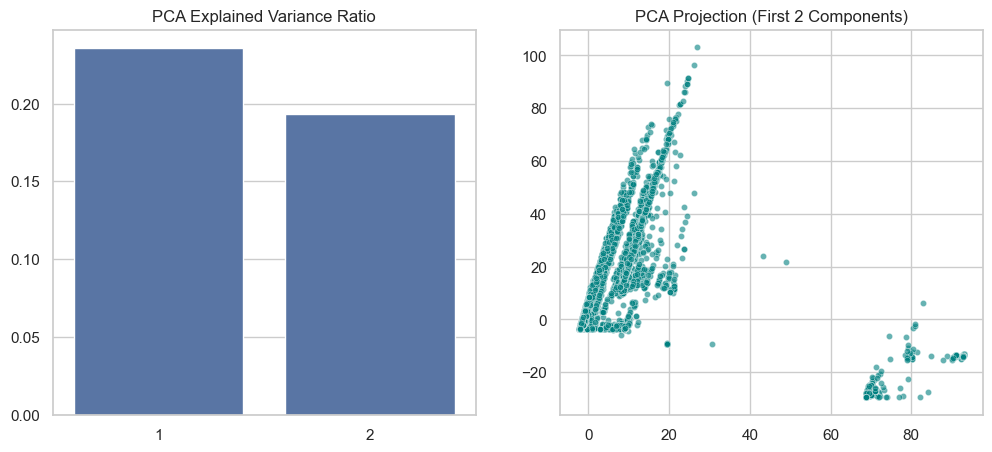


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 9435
Original Index Label: 9435
PC1 Value: 92.99
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
ci_000_is_missing    13.285776
ck_000_is_missing    13.285776
cj_000_is_missing    13.285776
by_000_is_missing    11.218190
ao_000_is_missing    10.043200
Name: 9435, dtype: float64

--- PCA Loadings Inspection (PC1) ---


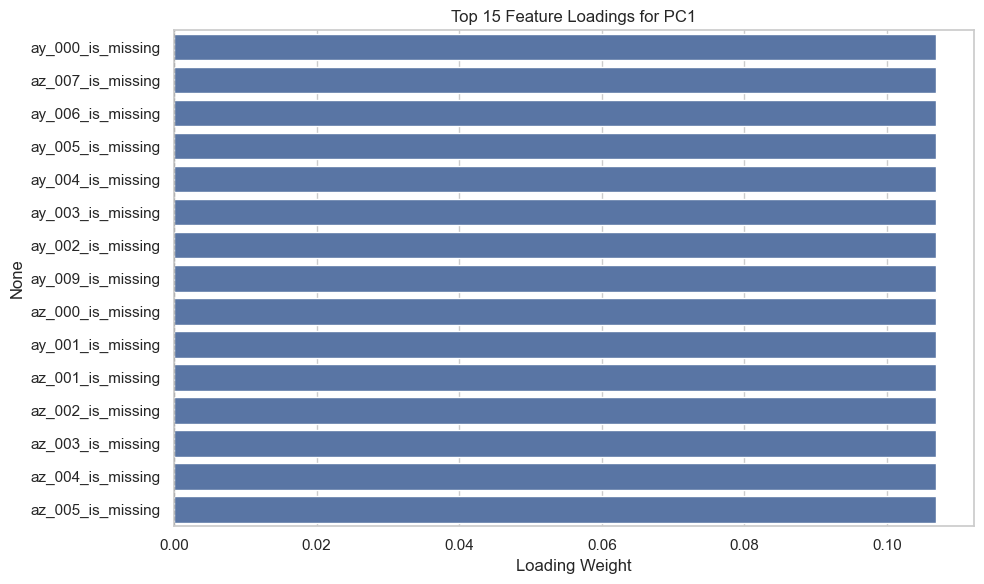

ay_000_is_missing    0.106842
az_007_is_missing    0.106842
ay_006_is_missing    0.106842
ay_005_is_missing    0.106842
ay_004_is_missing    0.106842
ay_003_is_missing    0.106842
ay_002_is_missing    0.106842
ay_009_is_missing    0.106842
az_000_is_missing    0.106842
ay_001_is_missing    0.106842
az_001_is_missing    0.106842
az_002_is_missing    0.106842
az_003_is_missing    0.106842
az_004_is_missing    0.106842
az_005_is_missing    0.106842
dtype: float64

In [6]:
from sklearn.preprocessing import StandardScaler

# Scale the data (Critical for PCA)
print("Scaling data...")
scaler = StandardScaler()
X_scaled_np = scaler.fit_transform(X_clean)

X_viz_selected = pd.DataFrame(X_scaled_np, columns=X_clean.columns, index=X_clean.index)

# 1. PCA Analysis (on selected features)
print(f"\n--- PCA Analysis (Top {(X_clean.shape[1])} Features) ---")
pca_df = pca_inspect(X_viz_selected)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_selected.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")

# Use iloc because outlier_idx is the row position from PCA, not the dataframe label

print(X_viz_selected.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_selected, component_idx=0)


--- Correlation Heatmap (Top 323 Features) ---


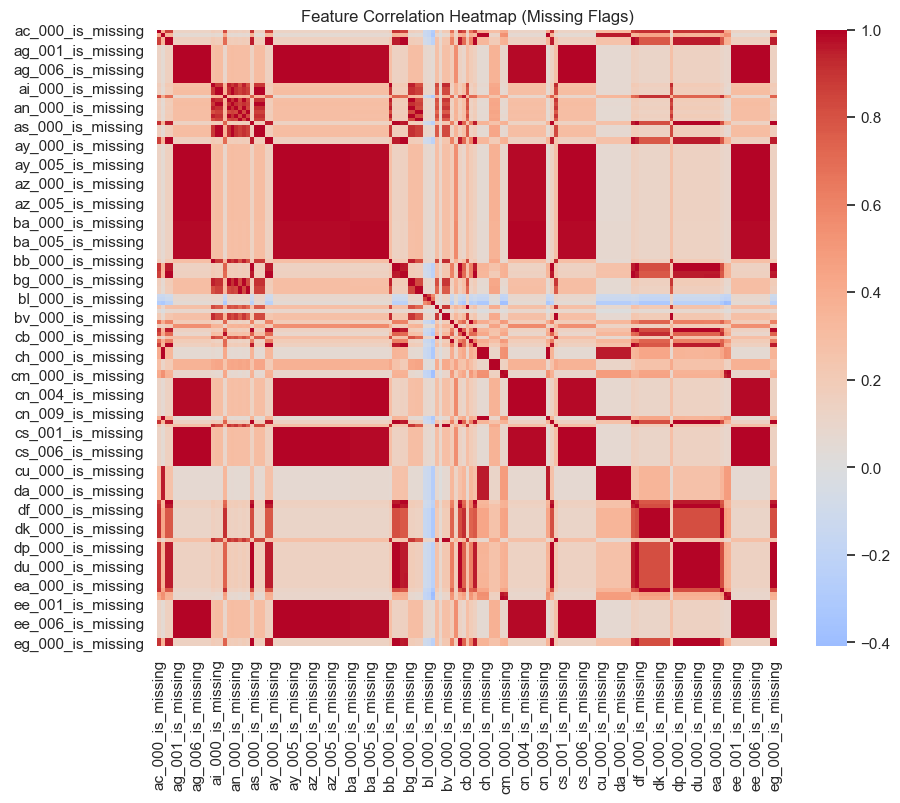

,Feature1,Feature2,Correlation
0,ac_000_is_missing,ae_000_is_missing,0.859135
1,ac_000_is_missing,af_000_is_missing,0.859135
2,ac_000_is_missing,ak_000_is_missing,0.822481
3,ac_000_is_missing,ar_000_is_missing,0.898759
4,ac_000_is_missing,av_000_is_missing,0.859135
...,...,...,...
5307,eg_000_is_missing,du_000_is_missing,0.998654
5308,eg_000_is_missing,dv_000_is_missing,0.998654
5309,eg_000_is_missing,dy_000_is_missing,0.999808
5310,eg_000_is_missing,eb_000_is_missing,0.815062


In [7]:
# 2. Correlation Heatmap (on "is_missing" features)
print(f"\n--- Correlation Heatmap (Top {X_clean.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_selected, only_missing=True) 

Our correlation table reveals the **physical architecture of the truck's sensor network**.

### 1\. The Physical Interpretation: "Module-Level Missingness"

In modern heavy trucks (like Scanias), sensors are not wired individually to the main computer. They are wired into **Electronic Control Units (ECUs)** or gathered into **wiring harnesses**.

  * **The "Power Strip" Effect:** If `ac_000`, `ae_000`, and `af_000` are 85%+ correlated in missingness, it implies they are likely plugged into the **same ECU** or share the same **power supply/data bus**.
  * **The Failure Mode:** When that specific ECU fails (or the cable is cut), *every* sensor attached to it goes `NaN` simultaneously.

Our PCA (PC1) isn't just picking up "Sensor X is broken"; it is picking up **"Subsystem Y is offline."**

### 2\. Why this matters for our Model

We have **massive multicollinearity** in your missingness flags.

  * **The Evidence:** `eg_000` and `du_000` have `0.998654` correlation.
  * **The Problem:** You currently have two features that tell the model the *exact same thing*.
      * `eg_000_is_missing = 1`
      * `du_000_is_missing = 1`
  * **The Consequence:** This dilutes feature importance. LightGBM might split on `eg` in one tree and `du` in another, making it hard to see that the **ROOT CAUSE** is the underlying module they share.

### 3\. The Solution: "Missingness Clustering"

Instead of feeding 100+ highly correlated `_is_missing` columns into your model, you should **cluster them** into "System Health" features.

Here is a strategy to reduce this noise and extract the structural signal.

#### Step A: Visualize the Clusters (The Dendrogram)

This will visually group the sensors into their physical hardware modules.


#### Step B: Feature Engineering (The Fix)

If `eg`, `du`, and `dv` are 99% correlated, replace them with a single feature called `Cluster_A_Missing`.

### 4\. Interpretation for RCA

By doing this, your Root Cause Analysis becomes much clearer:

  * **Before:** "Root cause is `eg_000_is_missing`... or maybe `du_000_is_missing`?"
  * **After:** "Root cause is `Module_4_Connectivity`."
      * You can then look up which sensors are in Module 4 and tell the mechanic: *"Check the wiring harness for the Gearbox Control Unit."*


--- PCA Analysis (Physical Sensors Only) ---
Explained variance ratio: 0.355


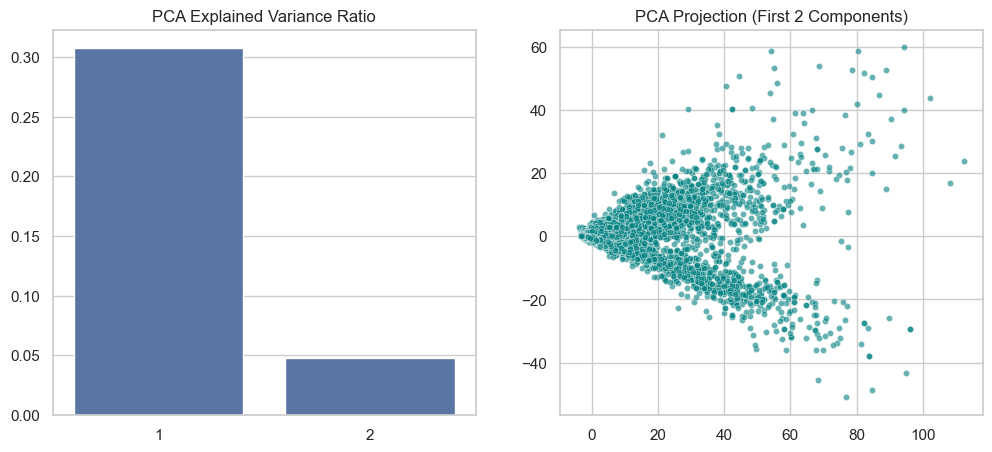

In [8]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_clean.columns if not c.endswith('_is_missing')]
X_physical = X_clean[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis (Physical Sensors Only) ---")
pca_df = pca_inspect(X_viz_physical)


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 56152
Original Index Label: 56153
PC1 Value: 112.44
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
cn_002    32.584703
ee_003    31.958217
az_004    29.205263
bi_000    28.220728
ba_001    27.137061
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


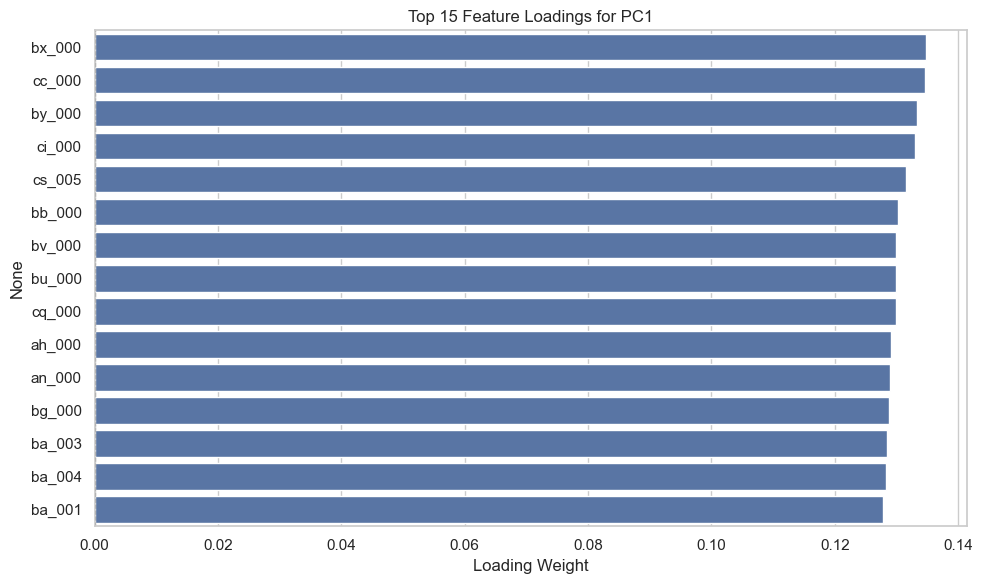

bx_000    0.134757
cc_000    0.134689
by_000    0.133332
ci_000    0.132969
cs_005    0.131515
bb_000    0.130233
bv_000    0.129975
bu_000    0.129975
cq_000    0.129975
ah_000    0.129079
an_000    0.128926
bg_000    0.128870
ba_003    0.128543
ba_004    0.128372
ba_001    0.127791
dtype: float64

In [9]:
# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)


--- Correlation Heatmap (Top 162 Features) ---


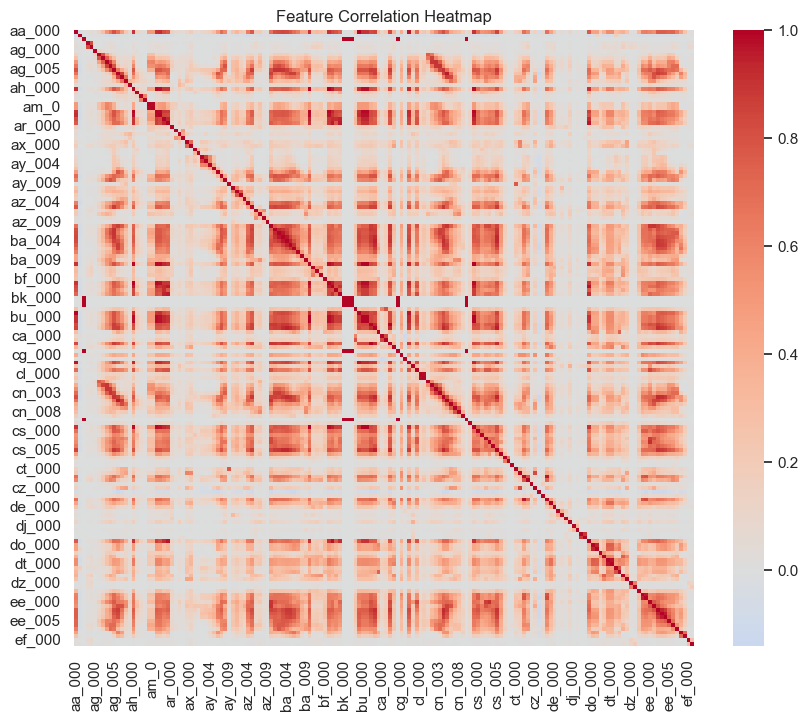

,Feature1,Feature2,Correlation
0,aa_000,ah_000,0.898952
1,aa_000,an_000,0.905110
2,aa_000,ao_000,0.910931
3,aa_000,ap_000,0.813182
4,aa_000,ba_001,0.809445
...,...,...,...
747,ee_004,by_000,0.863133
748,ee_004,cn_004,0.876817
749,ee_004,cs_005,0.851758
750,ee_004,ee_002,0.875882


In [9]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

In [10]:
# Feature Engineering & Selection
X_engineered = create_engineered_feature_set(X_clean)
X_test_engineered = create_engineered_feature_set(X_test_clean)

Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296
Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 323 -> New engineered feature count: 296



--- PCA Analysis (Physical Sensors Only) ---
Explained variance ratio: 0.268


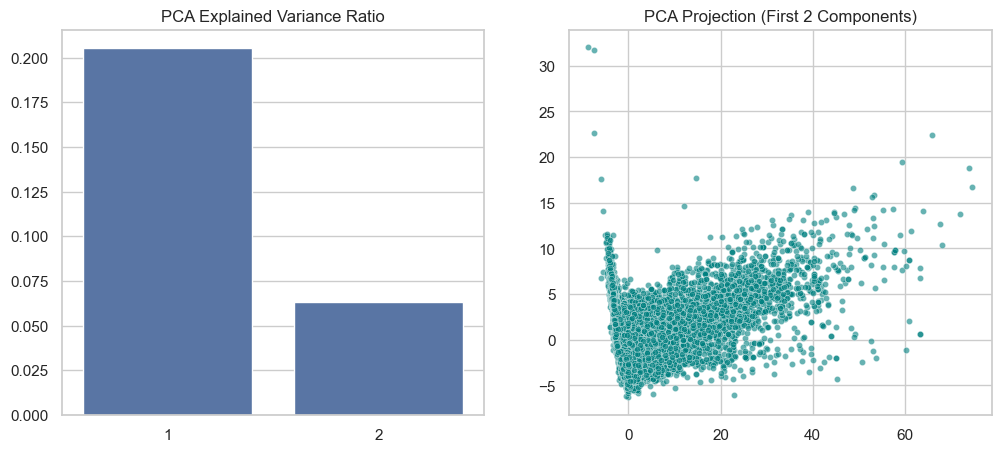


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 56152
Original Index Label: 56153
PC1 Value: 74.63
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
bi_000    28.220728
dc_000    26.131723
cx_000    21.372122
ap_000    20.740802
ec_00     20.524099
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


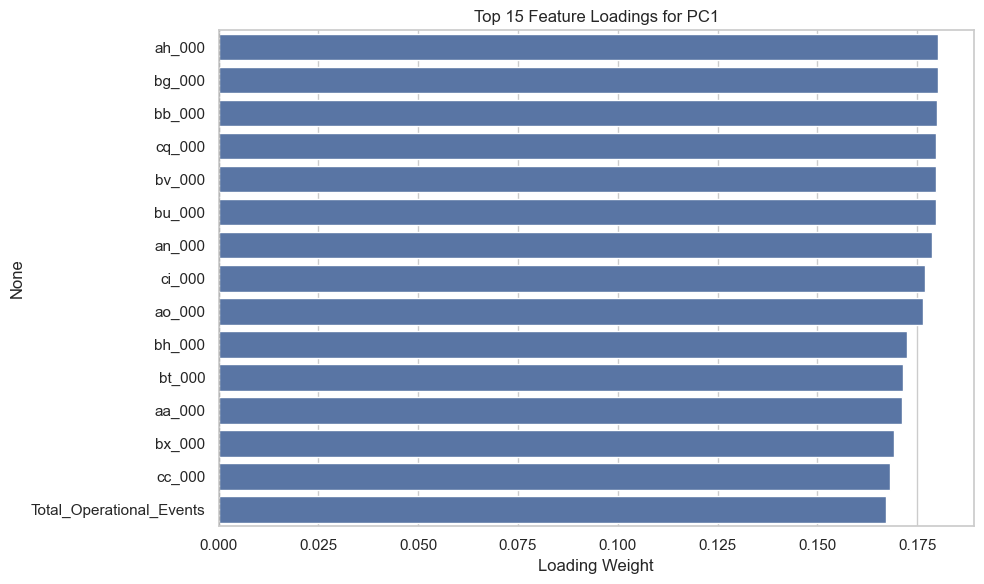

ah_000                      0.180225
bg_000                      0.180119
bb_000                      0.179911
cq_000                      0.179759
bv_000                      0.179759
bu_000                      0.179759
an_000                      0.178632
ci_000                      0.177074
ao_000                      0.176345
bh_000                      0.172512
bt_000                      0.171441
aa_000                      0.171274
bx_000                      0.169079
cc_000                      0.168149
Total_Operational_Events    0.167191
dtype: float64

In [13]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_engineered.columns if not c.endswith('_is_missing')]
X_physical = X_engineered[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis (Physical Sensors Only) ---")
pca_df = pca_inspect(X_viz_physical)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)


--- Correlation Heatmap (Top 135 Features) ---


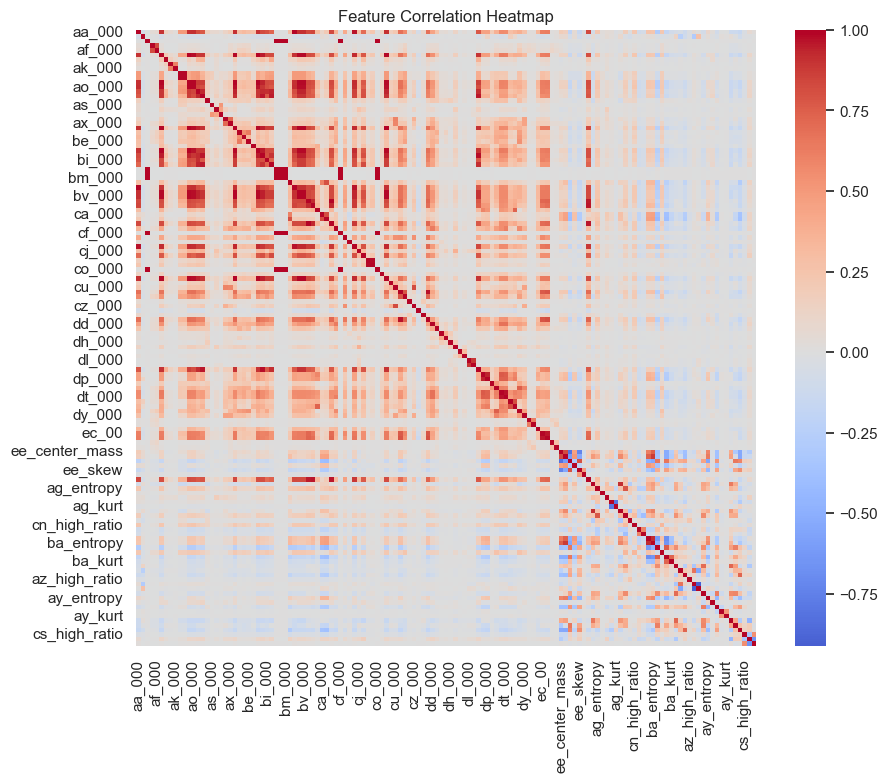

,Feature1,Feature2,Correlation
0,aa_000,ah_000,0.898952
1,aa_000,an_000,0.905110
2,aa_000,ao_000,0.910931
3,aa_000,ap_000,0.813182
4,aa_000,bb_000,0.905604
...,...,...,...
413,ba_center_mass,ba_entropy,0.920729
414,ba_entropy,ee_entropy,0.876816
415,ba_entropy,ba_center_mass,0.920729
416,az_skew,az_kurt,-0.910869


In [14]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

## 5. Clustering Analysis

In [11]:
# Preprocess data
preprocessor_clustering = ScaniaPreprocessor(reduce_missingness=True, cluster_threshold=0.20)
X_clean_reduced = preprocessor_clustering.fit_transform(X_train_raw)
X_test_clean_reduced = preprocessor_clustering.transform(X_test_raw)

print(f"Preprocessed train shape: {X_clean.shape}")
print(f"Preprocessed test shape: {X_test_clean.shape}")

Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
Preprocessing Summary:
  - Dropping 7 columns with > 70% missing values: ['ab_000', 'bn_000', 'bo_000', 'bp_000', 'bq_000', 'br_000', 'cr_000']
  - Dropping 1 constant columns: ['cd_000']
  - Retaining 162 columns.


/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89836e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89838e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89834e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.89825e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.26005e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Clustering Missingness: Compressed 161 _is_missing flags into 13 modules (Threshold=0.2).
Preprocessed train shape: (59999, 323)
Preprocessed test shape: (16000, 323)


In [12]:
# Feature Engineering & Selection
X_engineered_reduced = create_engineered_feature_set(X_clean_reduced)
X_test_engineered_reduced = create_engineered_feature_set(X_test_clean_reduced)

Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 175 -> New engineered feature count: 148
Identified 7 histogram families: ['ee', 'ag', 'cn', 'ba', 'az', 'ay', 'cs']
Engineering physics features for 7 groups...
Generated 49 features (Sum, Mass, Entropy, Skew, Kurt).
Detected 7 histogram sum features. Analyzing redundancy...
Dropped 6 redundant sum features: ['ee_sum', 'cn_sum', 'ba_sum', 'az_sum', 'ay_sum', 'cs_sum']
Renamed 'ag_sum' to 'Total_Operational_Events'.
Replaced 70 raw bins with 49 physics features.
Original feature count: 175 -> New engineered feature count: 148



--- PCA Analysis for 146 features ---
Explained variance ratio: 0.254


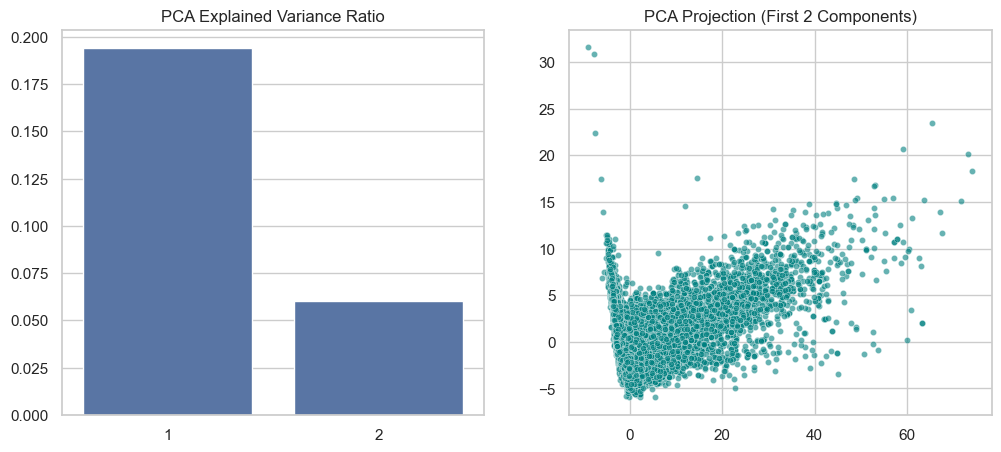


--- Outlier Identification ---
The extreme outlier is at Row Position (iloc): 56152
Original Index Label: 56153
PC1 Value: 74.13
Class Label: 0
Top 5 Feature Values for this Outlier (Z-scores):
bi_000    28.220728
dc_000    26.131723
cx_000    21.372122
ap_000    20.740802
ec_00     20.524099
Name: 56153, dtype: float64

--- PCA Loadings Inspection (PC1) ---


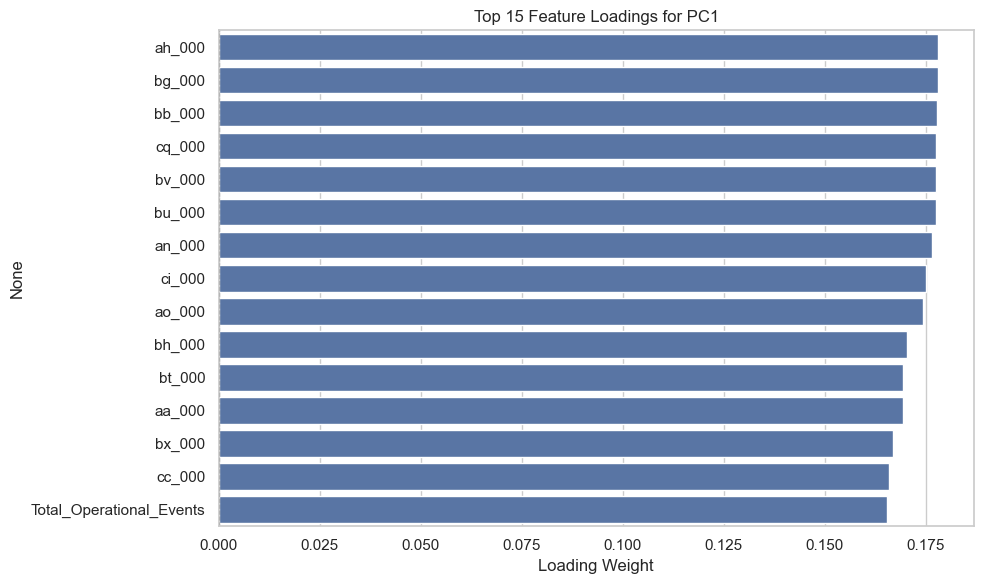

ah_000                      0.178017
bg_000                      0.177914
bb_000                      0.177690
cq_000                      0.177537
bv_000                      0.177537
bu_000                      0.177537
an_000                      0.176564
ci_000                      0.174968
ao_000                      0.174317
bh_000                      0.170306
bt_000                      0.169399
aa_000                      0.169236
bx_000                      0.166845
cc_000                      0.165960
Total_Operational_Events    0.165387
dtype: float64

In [18]:
# Filter out the engineered 'is_missing' columns
physical_cols = [c for c in X_engineered.columns]
X_physical = X_engineered[physical_cols]

# Scale ONLY the physical columns
scaler = StandardScaler()
X_scaled_physical = scaler.fit_transform(X_physical)
X_viz_physical = pd.DataFrame(X_scaled_physical, columns=physical_cols, index=X_clean.index)

# Now run PCA on the physical data
print(f"\n--- PCA Analysis for {X_viz_physical.shape[1]} features ---")
pca_df = pca_inspect(X_viz_physical)

# 1.1 Identify the Outlier
# Find the index of the point with the maximum PC1 value
outlier_idx = pca_df['PC1'].idxmax()
print(f"\n--- Outlier Identification ---")
print(f"The extreme outlier is at Row Position (iloc): {outlier_idx}")
print(f"Original Index Label: {X_viz_physical.index[outlier_idx]}")
print(f"PC1 Value: {pca_df.loc[outlier_idx, 'PC1']:.2f}")
print(f"Class Label: {y_train_raw.iloc[outlier_idx]}")
print("Top 5 Feature Values for this Outlier (Z-scores):")
# Use iloc because outlier_idx is the row position from PCA, not the dataframe label
print(X_viz_physical.iloc[outlier_idx].sort_values(ascending=False).head(5))

# 1.2 Inspect Loadings (Check for Outliers vs Multicollinearity)
print(f"\n--- PCA Loadings Inspection (PC1) ---")
inspect_pca_loadings(X_viz_physical, component_idx=0)



--- Correlation Heatmap (Top 146 Features) ---


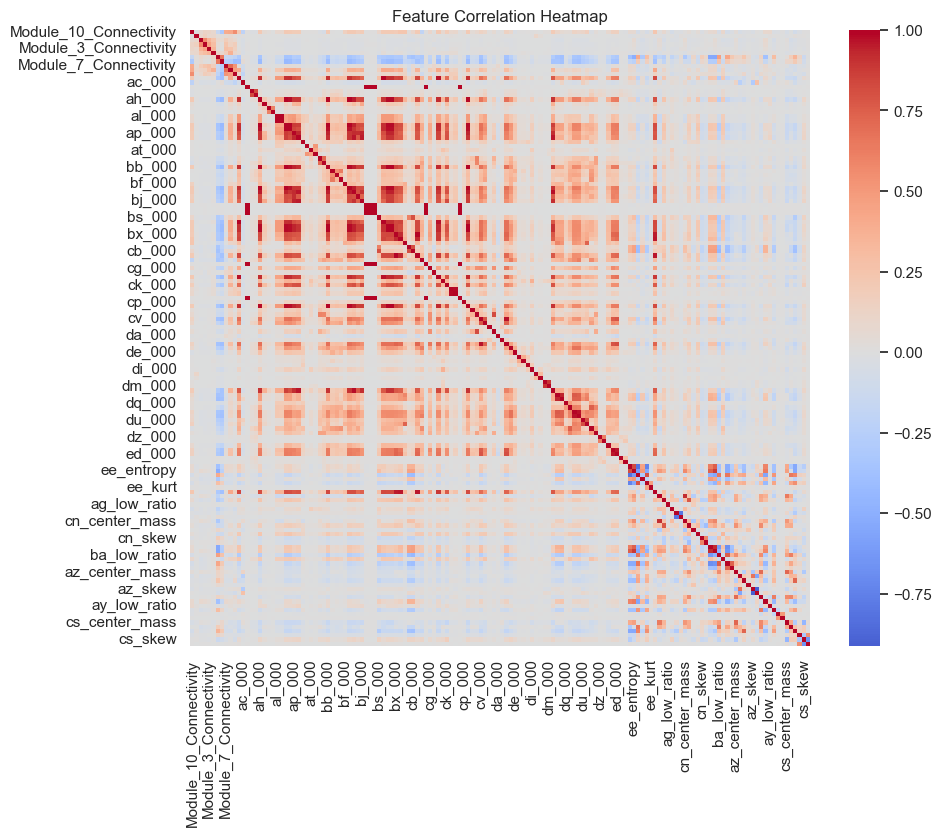

,Feature1,Feature2,Correlation
0,aa_000,ah_000,0.898952
1,aa_000,an_000,0.905110
2,aa_000,ao_000,0.910931
3,aa_000,ap_000,0.813182
4,aa_000,bb_000,0.905604
...,...,...,...
413,ba_center_mass,ba_entropy,0.920729
414,ba_entropy,ee_entropy,0.876816
415,ba_entropy,ba_center_mass,0.920729
416,az_skew,az_kurt,-0.910869


In [19]:
# 2. Correlation Heatmap (on selected features)
print(f"\n--- Correlation Heatmap (Top {X_physical.shape[1]} Features) ---")
plot_correlation_heatmap(X_viz_physical) 

## 6. Model Experimentation Grid
We run a comprehensive grid search over Models, Feature Sets, and Sampling Strategies.
**Metric:** Total Cost (FP=10, FN=500).

In [13]:
# Define Feature Sets
FEATURE_SETS = {
    #"Physics-Based Features": (X_engineered, X_test_engineered),
    "Physics-Based Features (Missingness Clustered)": (X_engineered_reduced, X_test_engineered_reduced),
    "Clean Features": (X_clean, X_test_clean), 
    #"Clean Features (Missingness Clustered)": (X_clean_reduced, X_test_clean_reduced),
}

# Define Models
MODELS = get_models(random_state=42)
MODELS = {name: model for name, model in MODELS.items() if name in ["LightGBM"]}

# Define Samplers
SAMPLERS = {
    "No Sampling": None,
    #"SMOTE": "smote",
    "Gaussian Copula": "copula" # Uncomment to include
}

# Define Sampling Percentages
SAMPLING_PCTS = [0.20, 0.40]

# Define Tuning Strategies
TUNING = {
    "Tuned Threshold": True,
    #"Fixed 0.5": False
}

In [12]:
MODELS


{'LightGBM': LGBMClassifier(random_state=42, verbose=-1),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=None,
               n_jobs=None, num_parallel_tree=None, random_state=42, ...)}

In [14]:
# Run the Grid
results_df = run_experiment_grid(
    models=MODELS,
    feature_sets=FEATURE_SETS,
    samplers=SAMPLERS,
    tuning_strategies=TUNING,
    sampling_percentages=SAMPLING_PCTS,
    y_train=y_train_raw,
    n_cv_splits=5, # Reduced for speed in demo
    verbose=True
)

--- STARTING EXPERIMENT MATRIX ---

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
AUC 0.988±0.004 | Macro-F1 0.750 | Cost 7090±551 | thr(median) 0.0025441396988731897 | fit 5.46s | pred 0.03s

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.2
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56640
Balancing complete. New dataset size: 56638
Balancing complete. New dataset size: 56638
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56638
Balancing complete. New dataset size: 56638
AUC 0.989±0.004 | Macro-F1 0.764 | Cost 7164±837 | thr(median) 0.00833075665869442 | fit 11.80s | pred 0.04s

RUNNING: LightGBM | Physics-Based Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.4
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 7

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is 

Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 66078
Balancing complete. New dataset size: 66080
Balancing complete. New dataset size: 66078
Balancing complete. New dataset size: 66078
Balancing complete. New dataset size: 66078
AUC 0.990±0.003 | Macro-F1 0.779 | Cost 7412±774 | thr(median) 0.009546624652046937 | fit 16.23s | pred 0.02s

RUNNING: LightGBM | Clean Features | No Sampling | Tuned Threshold
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 32

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...
Balancing: 800 minority, 47200 majority.
Target ratio: 0.2 -> Target minority count: 9440
Synthesizing 8640 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56638
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56638
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56638
Balancing complete. New dataset size: 56638
Balancing complete. New dataset size: 56640
AUC 0.989±0.004 | Macro-F1 0.765 | Cost 7018±813 | thr(median) 0.007102764424668319 | fit 27.10s | pred 0.04s

RUNNING: LightGBM | Clean Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.4
Running 5-fold CV with n_jobs=-1...
Dropping 0 columns with > 70% missing values: []
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Preprocessing Summary:
  - Retaining 323 columns.
Droppin

/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.4 -> Target minority count: 18879
Synthesizing 18079 samples...
Balancing: 800 minority, 47199 majority.
Target ratio: 0.4 -> Target minority count: 18879
Synthesizing 18079 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47199 majority.
Target ratio: 0.4 -> Target minority count: 18879
Synthesizing 18079 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Balancing: 800 minority, 47200 majority.
Target ratio: 0.4 -> Target minority count: 18880
Synthesizing 18080 samples...


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 66078
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 66078
Balancing complete. New dataset size: 66078
Balancing complete. New dataset size: 66078
Balancing complete. New dataset size: 66080
AUC 0.988±0.004 | Macro-F1 0.765 | Cost 7478±503 | thr(median) 0.008707084845796943 | fit 35.13s | pred 0.03s

--- EXPERIMENT MATRIX COMPLETE ---


## 7. Experiment Results & Best Model Selection

,model,feature_set,selector,sampler,tuning,cost_mean,cost_std,auc_mean,f1_mean,fit_time_mean,run_name,sampling_percentage
4,LightGBM,Clean Features,None,Gaussian Copula,Tuned Threshold,7018.0,812.905899,0.989286,0.764588,27.104733,LightGBM | Clean Features | Gaussian Copula | ...,0.2
0,LightGBM,Physics-Based Features (Missingness Clustered),None,No Sampling,Tuned Threshold,7090.0,550.708634,0.988335,0.750116,5.460905,LightGBM | Physics-Based Features (Missingness...,NaN
1,LightGBM,Physics-Based Features (Missingness Clustered),None,Gaussian Copula,Tuned Threshold,7164.0,837.200096,0.989262,0.764184,11.802045,LightGBM | Physics-Based Features (Missingness...,0.2
2,LightGBM,Physics-Based Features (Missingness Clustered),None,Gaussian Copula,Tuned Threshold,7412.0,773.521816,0.989970,0.778863,16.231403,LightGBM | Physics-Based Features (Missingness...,0.4
3,LightGBM,Clean Features,None,No Sampling,Tuned Threshold,7436.0,761.960629,0.988467,0.754362,5.417215,LightGBM | Clean Features | No Sampling | Tune...,NaN
5,LightGBM,Clean Features,None,Gaussian Copula,Tuned Threshold,7478.0,503.126227,0.987644,0.765110,35.133496,LightGBM | Clean Features | Gaussian Copula | ...,0.4


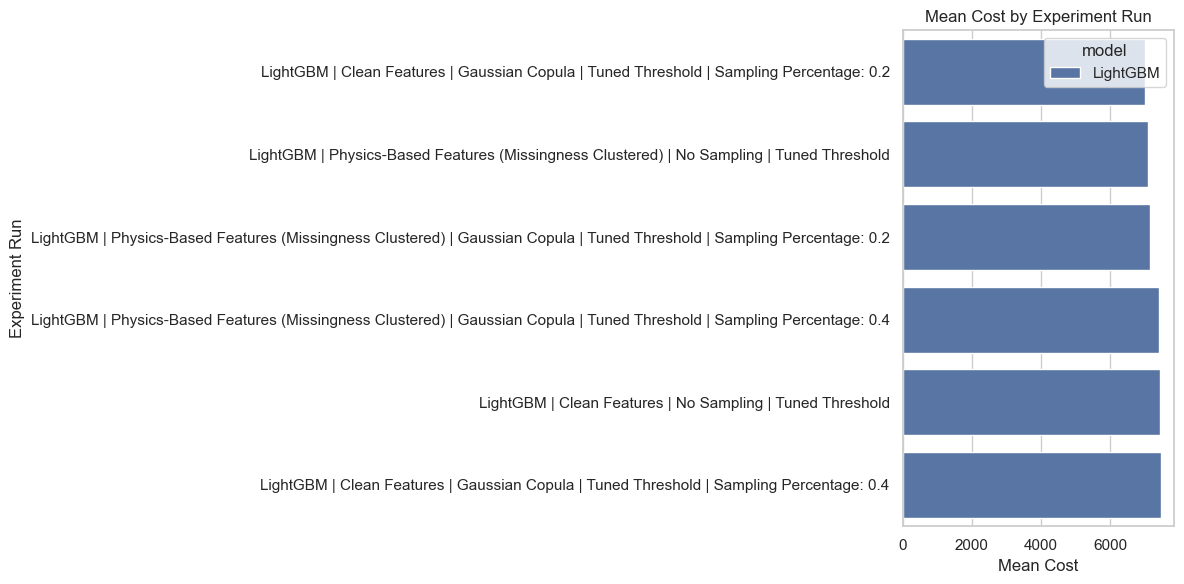

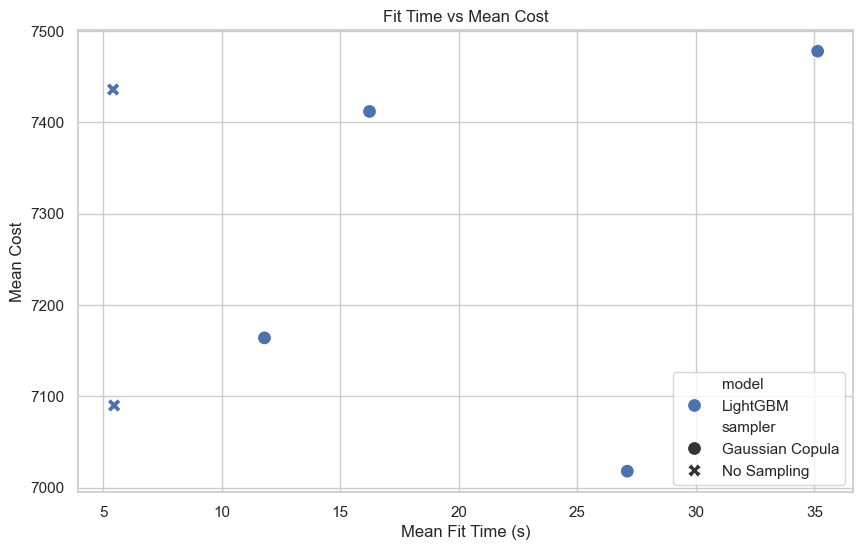

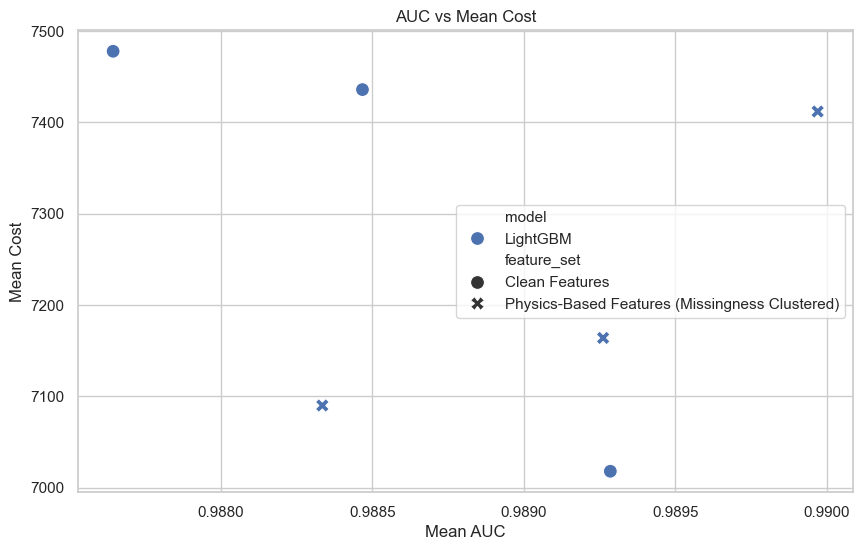

In [15]:
# Display Top Results
display(results_df.sort_values(by='cost_mean').head(20))

# Visualize Results
plot_experiment_results(results_df.sort_values(by='cost_mean').head(20))

No: 1 Run: LightGBM | Clean Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.2
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56638
Threshold tuned in 13.69s -> thr=0.011 (Val Cost=5750)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.2 -> Target minority count: 11799
Synthesizing 10799 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Test → AUC=0.995 | F1=0.822 | Cost=11600 | Recal

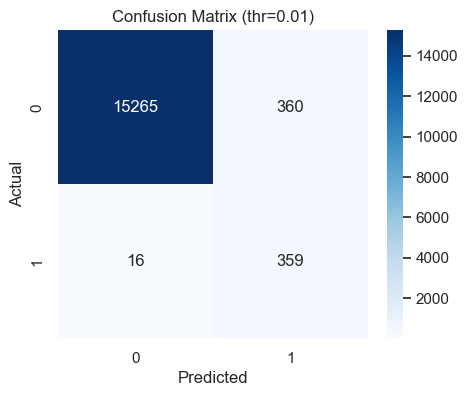

No: 2 Run: LightGBM | Physics-Based Features (Missingness Clustered) | No Sampling | Tuned Threshold
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Threshold tuned in 1.38s -> thr=0.005 (Val Cost=6110)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Test → AUC=0.995 | F1=0.795 | Cost=12060 | Recall=0.960 | Precision=0.441 | fit=1.67s | pred=0.02s | thr=0.005
Test CM (thr=0.005): FP=456, FN=15


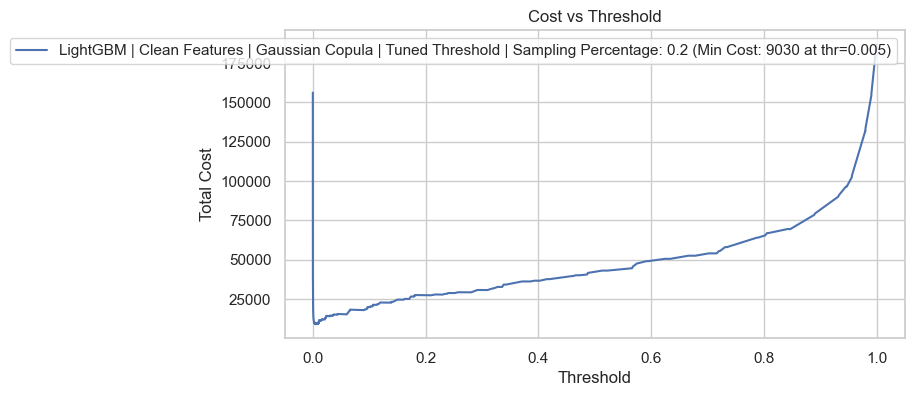

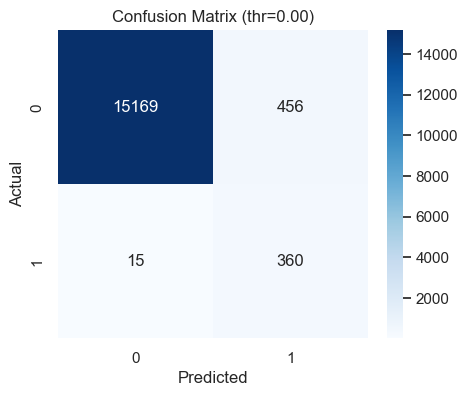

No: 3 Run: LightGBM | Physics-Based Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.2
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.2 -> Target minority count: 9439
Synthesizing 8639 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 56638
Threshold tuned in 6.94s -> thr=0.014 (Val Cost=5550)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.2 -> Target minority count: 11799
Synthesizing 10799 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 70798
Test → AUC=0.995 

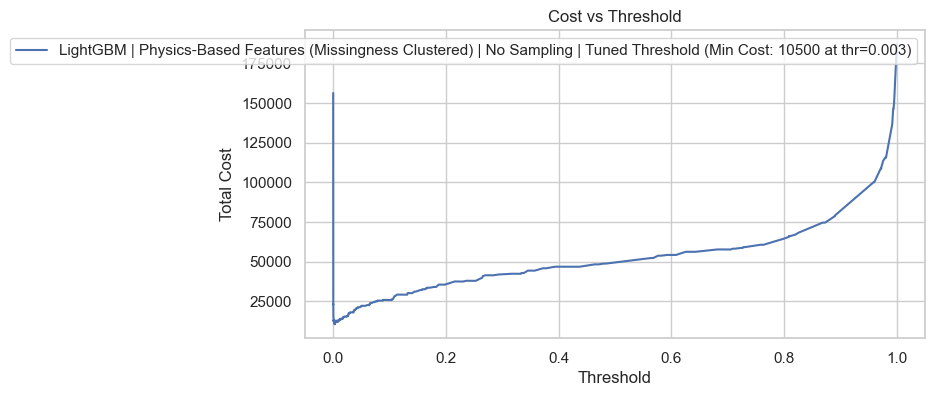

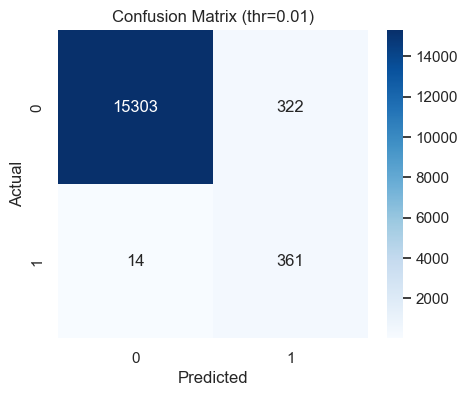

No: 4 Run: LightGBM | Physics-Based Features (Missingness Clustered) | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.4
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.4 -> Target minority count: 18879
Synthesizing 18079 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 66078
Threshold tuned in 8.62s -> thr=0.014 (Val Cost=6180)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.4 -> Target minority count: 23599
Synthesizing 22599 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 82598
Test → AUC=0.99

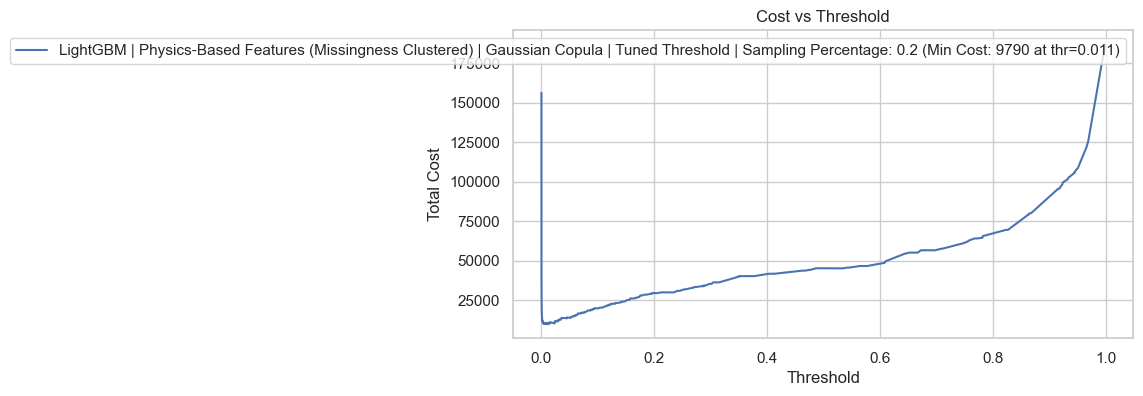

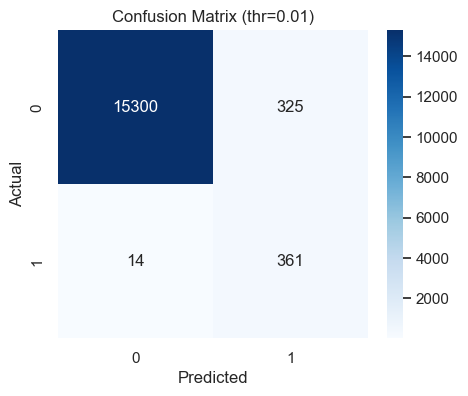

No: 5 Run: LightGBM | Clean Features | No Sampling | Tuned Threshold
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Threshold tuned in 2.64s -> thr=0.004 (Val Cost=6180)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Test → AUC=0.994 | F1=0.791 | Cost=10770 | Recall=0.968 | Precision=0.432 | fit=2.64s | pred=0.02s | thr=0.004
Test CM (thr=0.004): FP=477, FN=12


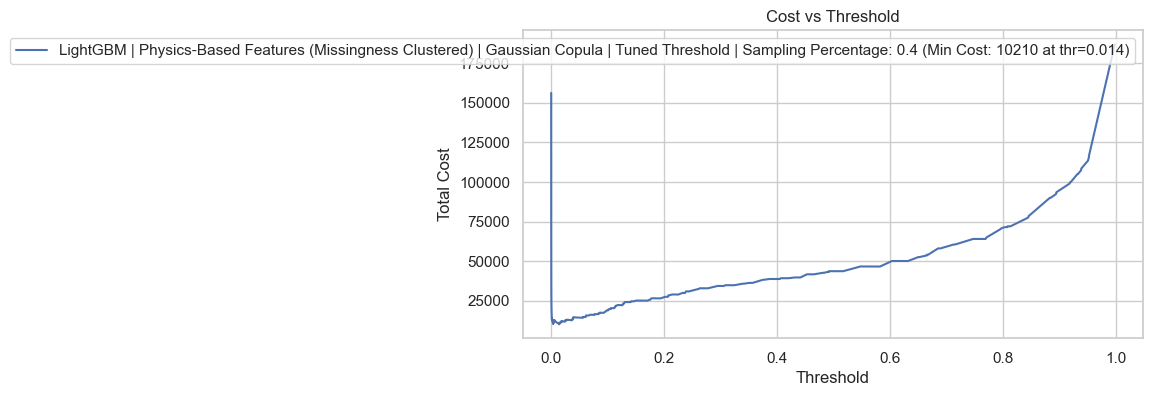

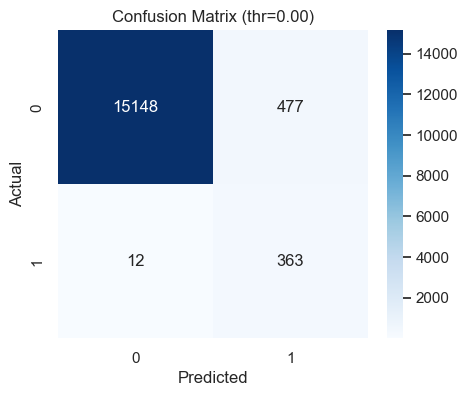

No: 6 Run: LightGBM | Clean Features | Gaussian Copula | Tuned Threshold | Sampling Percentage: 0.4
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Balancing: 800 minority, 47199 majority.
Target ratio: 0.4 -> Target minority count: 18879
Synthesizing 18079 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 66078
Threshold tuned in 18.23s -> thr=0.016 (Val Cost=5340)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 323 columns.
Final fit: Balancing with copula...
Balancing: 1000 minority, 58999 majority.
Target ratio: 0.4 -> Target minority count: 23599
Synthesizing 22599 samples...
Post-processing synthetic data to enforce physical constraints...
Balancing complete. New dataset size: 82598
Test → AUC=0.996 | F1=0.838 | Cost=12080 | Rec

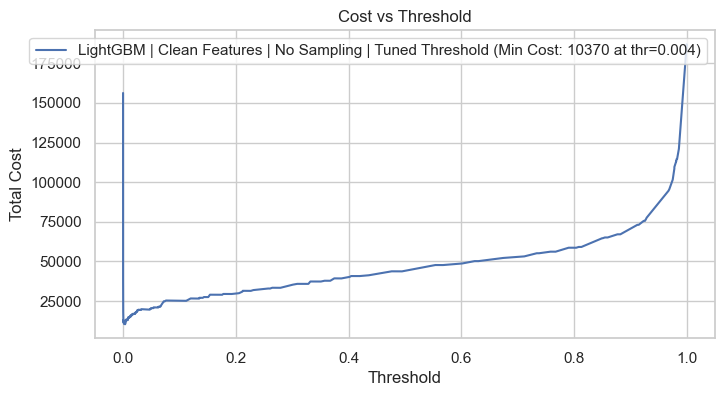

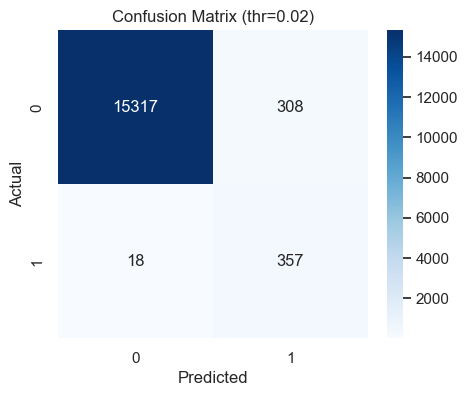

In [ ]:
from challenge.rca.pipeline import run_rca_pipeline

# 1. Define Target Feature Sets for RCA
target_rca_sets = [
    "Physics-Based Features (Missingness Clustered)", 
    "Clean Features"
]

# 2. Iterate through ALL runs for standard analysis (Top 6)
print("--- Top 6 Models Analysis ---")
for i in range(6):
    if not results_df.empty:
        best_run = results_df.sort_values(by='cost_mean').iloc[i]
        print(f"No: {i+1} Run: {best_run['run_name']}")
        
        # Configuration
        model = MODELS[best_run['model']]
        fset_name = best_run['feature_set']
        X_tr, X_te = FEATURE_SETS[fset_name]
        
        sampler_name = best_run['sampler']
        sampler_key = SAMPLERS[sampler_name]
        best_pct = best_run.get('sampling_percentage', 'auto')
        
        # Evaluate
        test_results = evaluate_on_test(
            model=model,
            X_train=X_tr,
            y_train=y_train_raw,
            X_test=X_te,
            y_test=y_test_raw,
            sampler=sampler_key,
            sampling_strategy=best_pct if sampler_key else 'auto',
            tune_if_none=True,
            verbose=False # Reduce verbosity for viewing
        )
        
        # Visuals
        probs = test_results['test_probabilities']
        plot_confusion(y_test_raw, probs, threshold=test_results['metrics']['Threshold'])
        plot_cost_threshold_curve(y_test_raw, probs, label=best_run['run_name'])

## 8. Root Cause Analysis (RCA)

### **1. Core Concept: SHAP Values**

SHAP (SHapley Additive exPlanations) values measure the impact of each feature on a specific prediction.

  - **Base Value ($E[f(x)]$):** The average prediction of the model across the training dataset.
  - **SHAP Value ($\phi$):** How much a specific feature pushes the prediction away from the base value.
  - **Equation:** `Prediction = Base Value + Sum(SHAP Values)`

### **2. Choosing the Right Explainer**

The type of model you are using determines which SHAP explainer is most efficient.

| Model Type | Recommended Explainer | Why? |
| :--- | :--- | :--- |
| **Tree-based** (XGBoost, LightGBM, Random Forest, CatBoost) | `shap.TreeExplainer` | Optimized for trees; extremely fast and accurate. |
| **Deep Learning** (TensorFlow, PyTorch) | `shap.DeepExplainer` | Approximates SHAP values for neural networks. |
| **Model-Agnostic** (Any model, e.g., SVM, KNN) | `shap.KernelExplainer` | Works for any model but is computationally expensive (slow). |
| **Automatic Selection** | `shap.Explainer` | Automatically chooses the best explainer based on the model passed. |


### **4. Key Visualization Interpretations**

#### **A. Waterfall Plot (`shap.plots.waterfall`)**

**Use for:** Explaining **one specific prediction**.

  - **X-axis:** The prediction value (e.g., probability or regression score).
  - **Y-axis:** Features contributing to this specific result.
  - **Red bars:** Pushed the prediction **higher**.
  - **Blue bars:** Pushed the prediction **lower**.
  - **Interpretation:** Starts at the bottom with the average prediction (base value) and adds/subtracts values to reach the final prediction at the top.

#### **B. Beeswarm Plot (`shap.plots.beeswarm`)**

**Use for:** Global feature importance and understanding feature effects across the **whole dataset**.

  - **Y-axis:** Features ordered by importance (top is most important).
  - **X-axis:** SHAP value (impact on model output).
  - **Color:** Feature value (Red = High, Blue = Low).
  - **Interpretation:**
      - If "Age" has **red dots on the right**, it means **higher age** leads to a **higher prediction**.
      - If "Income" has **blue dots on the right**, it means **lower income** leads to a **higher prediction**.


#### **C. Force Plot (`shap.plots.force`)**

**Use for:** Interactive visualization for single or multiple predictions.

  - Similar to the waterfall plot but condensed into a single horizontal bar.
  - Useful for stacking multiple predictions to see trends over a dataset (e.g., how explanations change over time).


#### **D. Bar Plot (`shap.plots.bar`)**

**Use for:** Simple global feature importance.

  - Shows the average absolute SHAP value for each feature.
  - Tells you **which** features matter most, but not **how** (unlike the beeswarm plot).


### **5. Important Notes**

  - **Data for `shap_values`:** When calculating SHAP values, you usually pass the **test set** or a sample of it, not the training set, to understand how the model generalizes.
  - **Interaction Values:** SHAP can also calculate interaction values to show how two features combined affect the prediction, distinct from their individual effects.

In [22]:
# 3. RCA Deep Dive: Best Run per Target Feature Set
print("\n" + "="*80)
print("RCA DEEP DIVE: Best Performing Models for Target Feature Sets")
print("="*80)


RCA DEEP DIVE: Best Performing Models for Target Feature Sets


In [23]:
import os
from challenge.rca.pipeline import run_rca_pipeline
# 1. Setup Output Directory
output_base_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'results', 'rca_results'))
os.makedirs(output_base_dir, exist_ok=True)
print(f"RCA Results will be saved to: {output_base_dir}")

for fset_target in target_rca_sets:
    # Filter for this feature set
    subset = results_df[results_df['feature_set'] == fset_target]
    
    if not subset.empty:
        # Get best run (lowest cost)
        best_run = subset.sort_values(by='cost_mean').iloc[0]
        run_name = best_run['run_name']
        print(f"\n>>> Processing Best Run for: {fset_target}")
        print(f">>> Run Name: {run_name}")
        
        # Unique prefix for this run's artifacts
        # sanitize name for filesystem
        safe_name = run_name.replace(" ", "_").replace("(", "").replace(")", "")
        file_prefix = f"{safe_name}_"
        
        # Re-evaluate to get fitted objects
        model = MODELS[best_run['model']]
        X_tr, X_te = FEATURE_SETS[fset_target]
        sampler_key = SAMPLERS[best_run['sampler']]
        best_pct = best_run.get('sampling_percentage', 'auto')
        
        test_results = evaluate_on_test(
            model=model,
            X_train=X_tr,
            y_train=y_train_raw,
            X_test=X_te,
            y_test=y_test_raw,
            sampler=sampler_key,
            sampling_strategy=best_pct if sampler_key else 'auto',
            tune_if_none=True,
            verbose=True
        )
        
        # --- RCA Execution ---
        print(f"\n[RCA] Launching Pipeline for {run_name}...")
        
        # Correctly grab the fitted model from results
        fitted_model = test_results['model']
        
        # Reprocess Data correctly
        prep = test_results['preprocessor']
        scaler = test_results['scaler']
        
        # Transform X_train to match what model sees
        X_imp = prep.transform(X_tr)
        X_sc = scaler.transform(X_imp)
        
        if hasattr(X_imp, 'columns'):
            X_dim_fixed = pd.DataFrame(X_sc, columns=X_imp.columns, index=X_imp.index)
        else:
            cols = getattr(X_tr, "columns", [f"feat_{i}" for i in range(X_sc.shape[1])])
            X_dim_fixed = pd.DataFrame(X_sc, columns=cols)
            
        Y_fixed = y_train_raw
        # Run RCA with Output controls
        run_rca_pipeline(
            fitted_model, 
            X_dim_fixed, 
            Y_fixed, 
            output_dir=output_base_dir,
            file_prefix=file_prefix
        )
        print(f"[RCA] Completed for {fset_target}.\n")
        print("-" * 40)
    else:
        print(f"\n[Warning] No runs found for feature set: {fset_target}")

RCA Results will be saved to: /Users/berkcalisir/School&Career/school-docs/Challenge@Stellantis/Challenge-Stellantis---CarGuardians/results/rca_results

>>> Processing Best Run for: Physics-Based Features (Missingness Clustered)
>>> Run Name: LightGBM | Physics-Based Features (Missingness Clustered) | No Sampling | Tuned Threshold
--- Tuning Threshold on Validation Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Threshold tuned in 1.57s -> thr=0.005 (Val Cost=6110)
--- Refitting on Full Train Data & Evaluating Test Set ---
Dropping 0 columns with > 70% missing values: []
Preprocessing Summary:
  - Retaining 148 columns.
Test → AUC=0.995 | F1=0.795 | Cost=12060 | Recall=0.960 | Precision=0.441 | fit=1.70s | pred=0.02s | thr=0.005
Test CM (thr=0.005): FP=456, FN=15

[RCA] Launching Pipeline for LightGBM | Physics-Based Features (Missingness Clustered) | No Sampling | Tuned Threshold...


TypeError: run_rca_pipeline() got an unexpected keyword argument 'output_dir'

In [16]:
def analyze_feature_relationships(X, y, reference_col, families=None):
    """
    Analyzes the relationship of a reference column (e.g., 'ay_002') against 
    cumulative feature families and the target class.
    
    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target vector.
        reference_col (str): The column to analyze (e.g., 'ay_002', 'bg_000').
        families (list): List of feature family prefixes to aggregate (e.g., ['ag', 'ay']).
    """
    if families is None:
        families = ['ag', 'ay', 'ba', 'cn', 'cs', 'ee']
        
    print(f"\n=== Analysis for Reference Column: {reference_col} ===")

    # --- TEST 1: Family Correlations & Scatter Plots ---
    n_families = len(families)
    n_cols = 3
    n_rows = (n_families + n_cols - 1) // n_cols
    
    plt.figure(figsize=(5 * n_cols, 5 * n_rows))
    
    for i, family in enumerate(families):
        # Get all columns for this family
        cols = [c for c in X.columns if c.startswith(family + '_') and c[-1].isdigit()]
        
        if not cols: 
            continue
        
        # Calculate Sum of the family for each truck
        family_sum = X[cols].sum(axis=1)
        
        # Calculate Correlation with reference_col
        corr, _ = spearmanr(X[reference_col], family_sum, nan_policy='omit')
        
        # Plot
        plt.subplot(n_rows, n_cols, i+1)
        plt.scatter(X[reference_col], family_sum, alpha=0.1, s=1)
        plt.title(f"{reference_col} vs Sum({family}_*)\nSpearman Corr: {corr:.4f}")
        plt.xlabel(reference_col)
        plt.ylabel(f"Total Events ({family})")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # --- TEST 2: The "Correlation King" Test ---
    print(f"\n--- Top 10 Features Correlated with {reference_col} ---")
    # Calculate correlations of EVERYTHING against reference_col
    correlations = X.corrwith(X[reference_col], method='spearman').abs()
    top_corrs = correlations.sort_values(ascending=False).head(11) # Top 10 + itself
    print(top_corrs)

    # --- TEST 3: The "Wear-Out" Test ---
    print(f"\n--- Class Distribution by {reference_col} ---")
    plt.figure(figsize=(10, 6))
    
    # Combine for plotting
    data_plot = pd.concat([X[reference_col], y.rename('class')], axis=1)
    
    sns.kdeplot(data=data_plot, x=reference_col, hue='class', common_norm=False, fill=True)
    plt.title(f"Distribution of {reference_col}: Healthy (0) vs Failure (1)")
    plt.show()

    # Check descriptive stats
    print(X[reference_col].groupby(y).describe())


=== Analysis for Reference Column: aa_000 ===


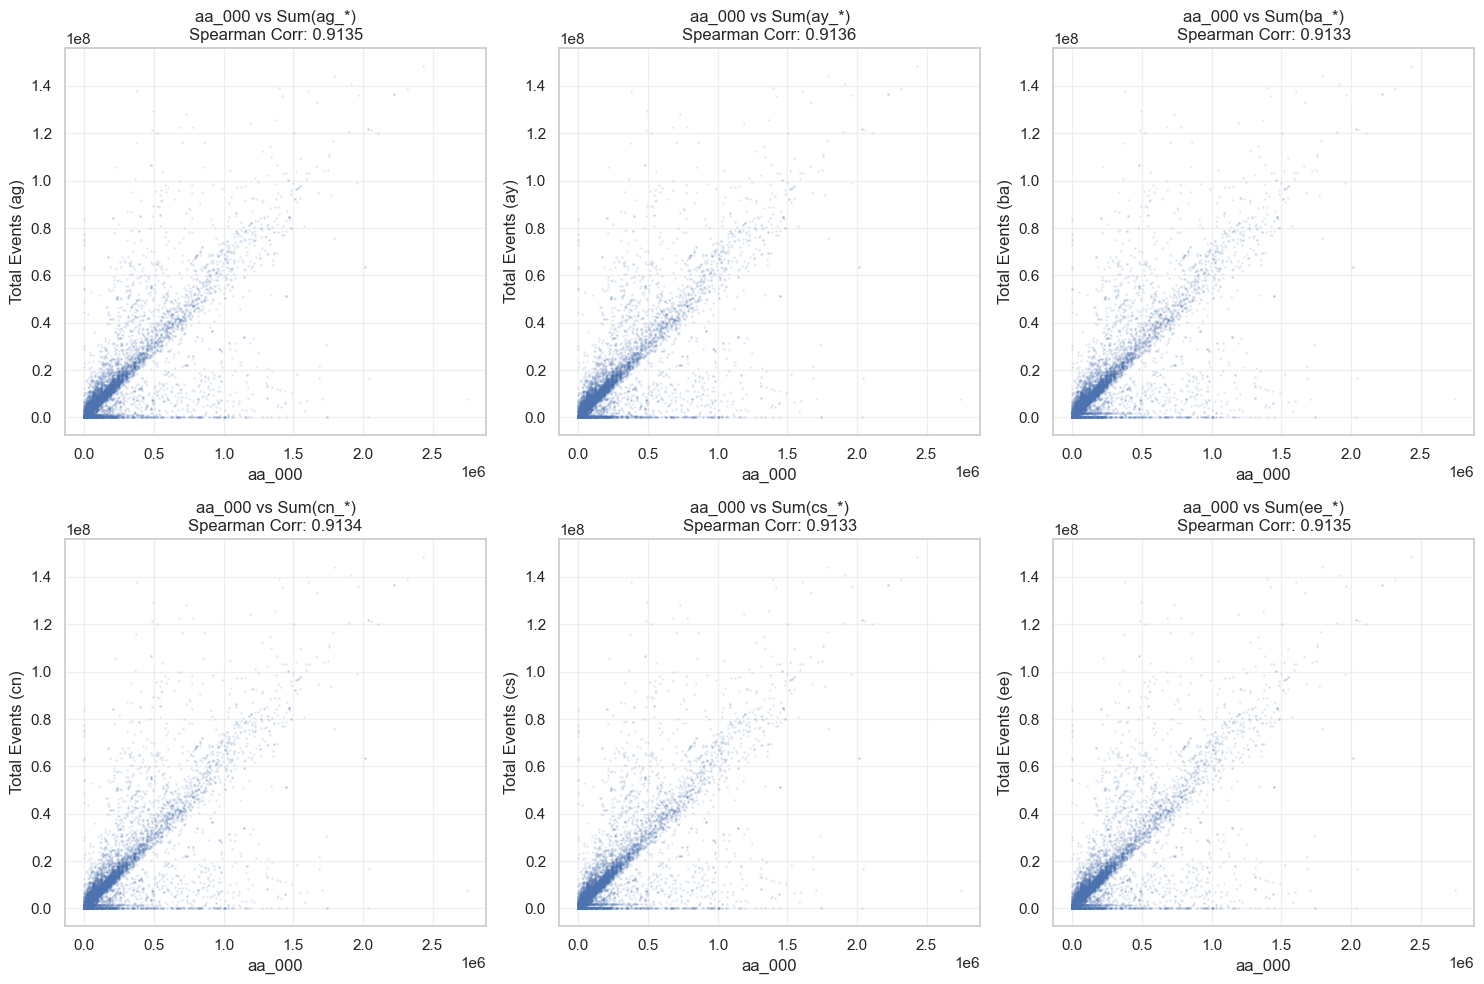


--- Top 10 Features Correlated with aa_000 ---
aa_000    1.000000
bt_000    0.995954
ci_000    0.976064
an_000    0.954444
ao_000    0.954245
bg_000    0.954128
ah_000    0.953988
bb_000    0.949197
bu_000    0.948667
cq_000    0.948667
bv_000    0.948667
dtype: float64

--- Class Distribution by aa_000 ---


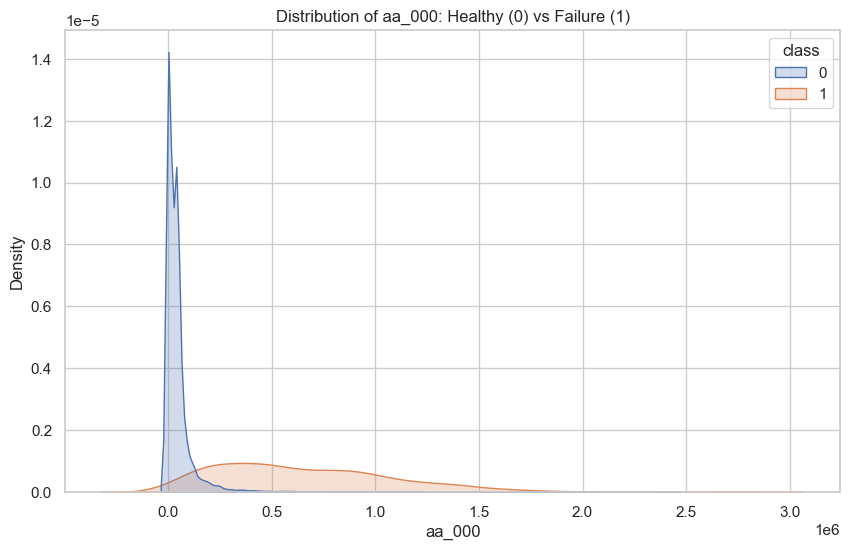

         count           mean            std  min       25%       50%  \
class                                                                   
0      58999.0   49160.331429  110029.541506  0.0     784.0   30414.0   
1       1000.0  659173.664000  434383.878466  0.0  318157.5  584994.0   

            75%        max  
class                       
0       45492.0  2434708.0  
1      930501.5  2746564.0  


In [17]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='aa_000')


=== Analysis for Reference Column: ci_000 ===


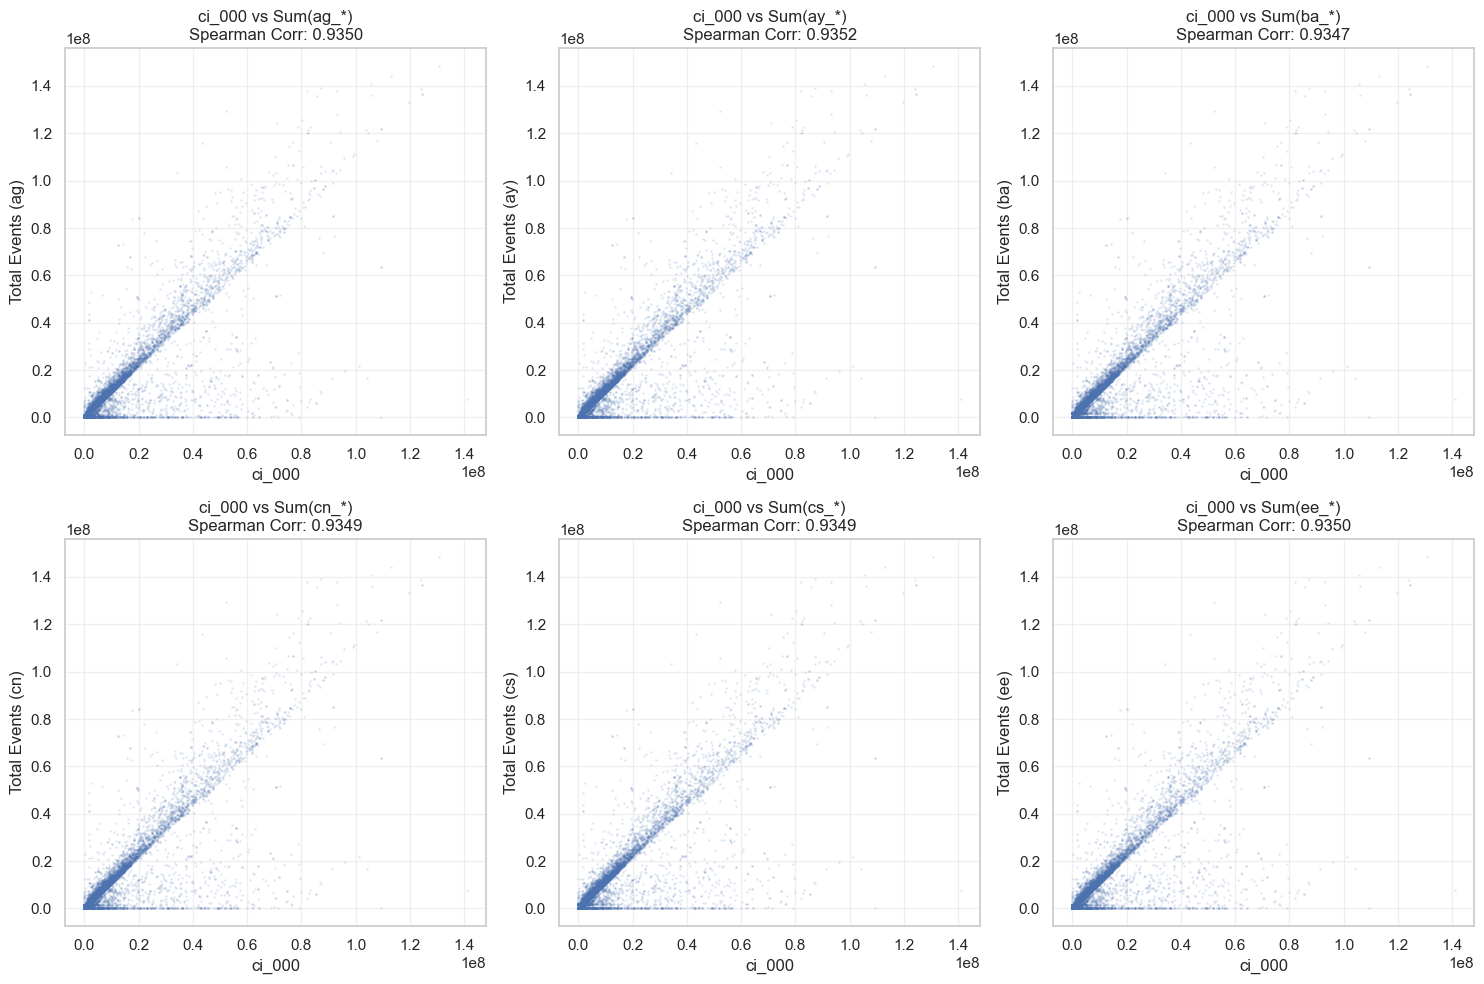


--- Top 10 Features Correlated with ci_000 ---
ci_000    1.000000
bt_000    0.979028
aa_000    0.976064
bg_000    0.975113
ah_000    0.974967
an_000    0.974477
bb_000    0.971386
cq_000    0.970830
bu_000    0.970830
bv_000    0.970830
ao_000    0.969598
dtype: float64

--- Class Distribution by ci_000 ---


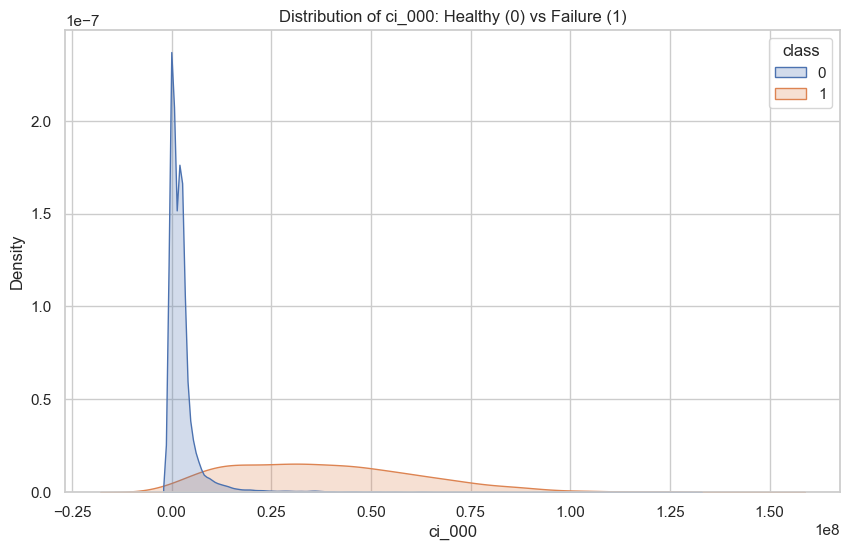

         count          mean           std      min          25%          50%  \
class                                                                           
0      58999.0  2.874413e+06  6.299395e+06     0.00     46202.40   1835494.08   
1       1000.0  3.870163e+07  2.372318e+07  3915.84  19768277.52  35874037.92   

               75%           max  
class                             
0       2820476.64  1.308788e+08  
1      54275865.84  1.409861e+08  


In [55]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='ci_000')


=== Analysis for Reference Column: bj_000 ===


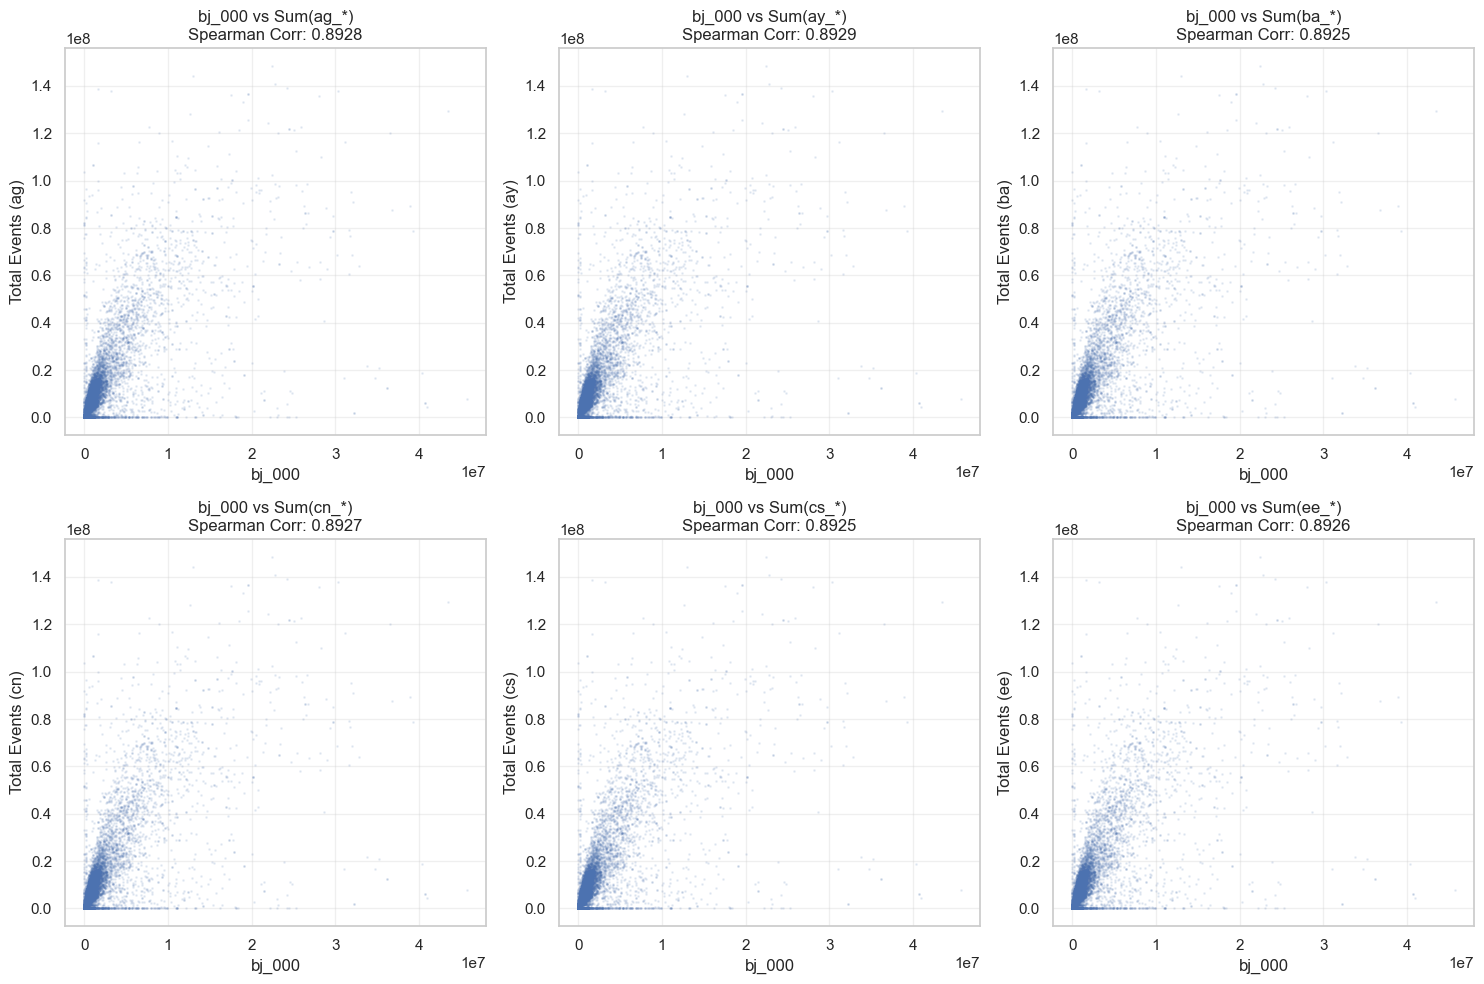


--- Top 10 Features Correlated with bj_000 ---
bj_000    1.000000
aq_000    0.980990
dn_000    0.980659
bh_000    0.974834
ap_000    0.969660
bb_000    0.956730
bv_000    0.955845
cq_000    0.955845
bu_000    0.955845
bg_000    0.950394
ah_000    0.950143
dtype: float64

--- Class Distribution by bj_000 ---


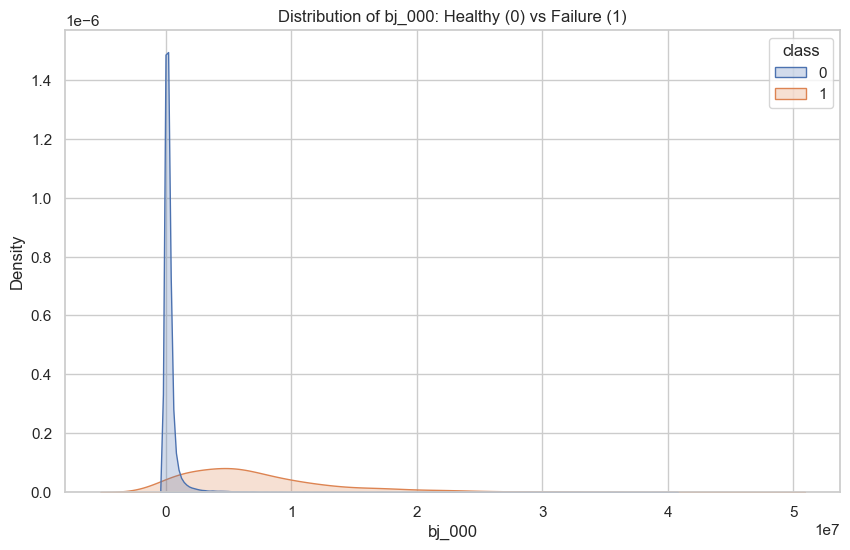

         count          mean           std  min        25%        50%  \
class                                                                   
0      58999.0  3.853239e+05  1.284270e+06  0.0     8427.0   152914.0   
1       1000.0  7.657120e+06  6.899819e+06  0.0  3114046.5  5851150.0   

             75%         max  
class                         
0       317358.0  40370758.0  
1      9988362.5  45736316.0  


In [54]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='bj_000')


=== Analysis for Reference Column: ai_000 ===


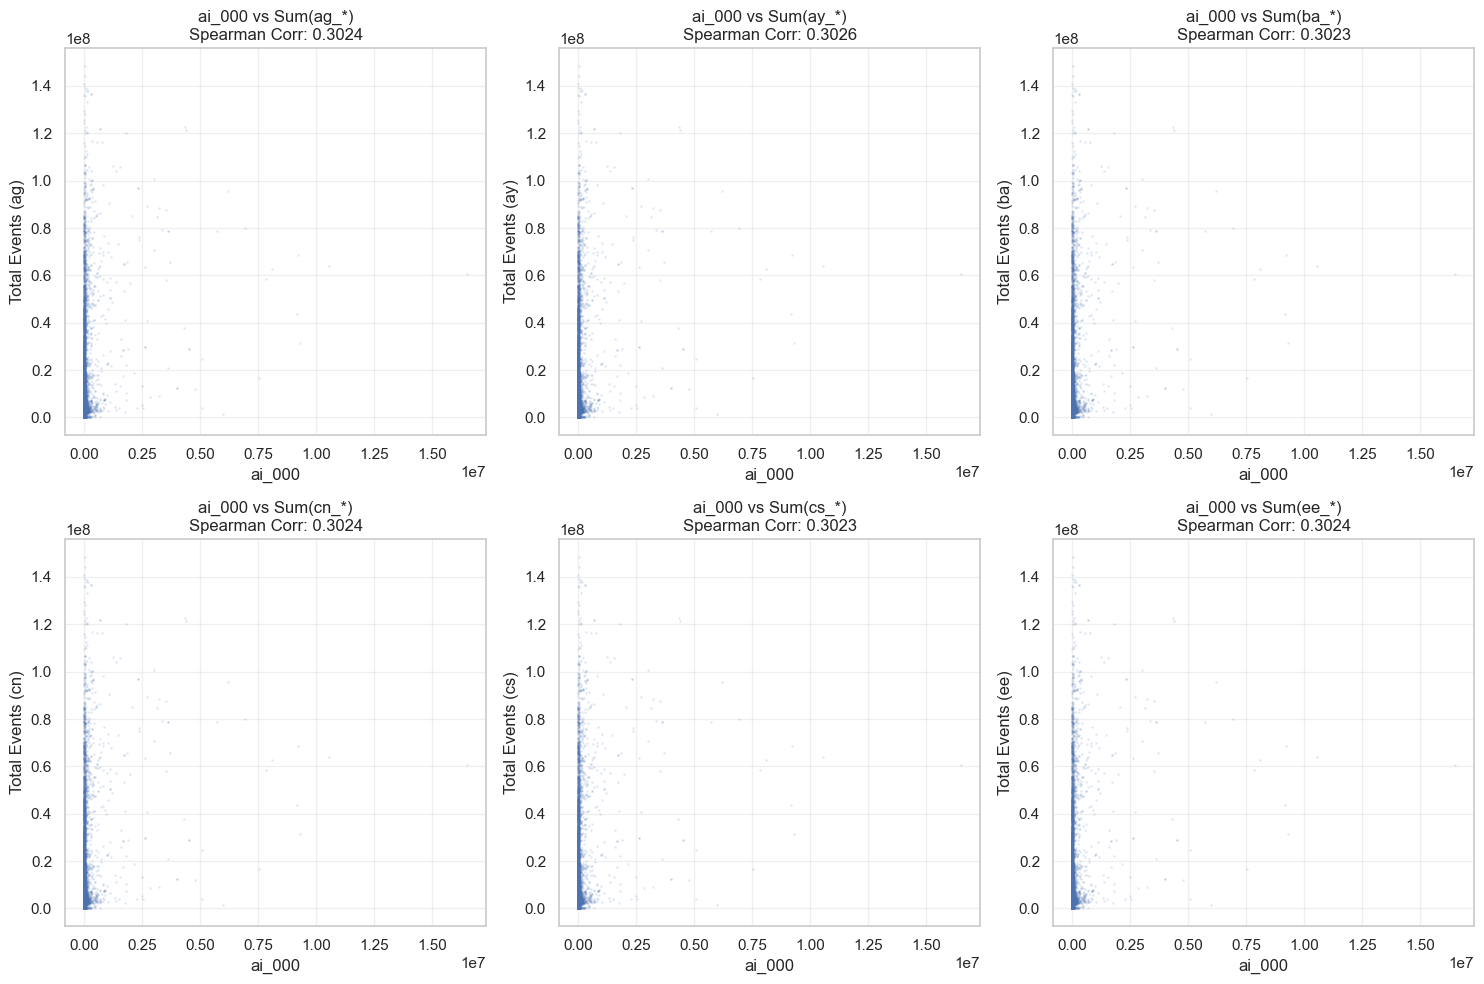


--- Top 10 Features Correlated with ai_000 ---
ai_000    1.000000
bj_000    0.382484
aq_000    0.375167
ap_000    0.364150
dn_000    0.363845
bh_000    0.349362
ck_000    0.337198
bi_000    0.332741
bb_000    0.321590
ah_000    0.320805
bu_000    0.320672
dtype: float64

--- Class Distribution by ai_000 ---


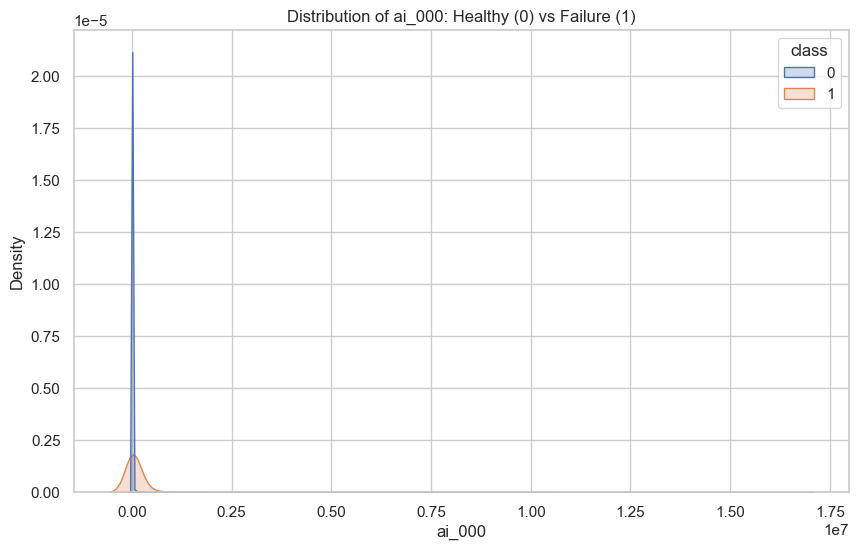

         count           mean            std  min  25%     50%      75%  \
class                                                                     
0      58999.0    6421.613553  128908.596354  0.0  0.0     0.0      0.0   
1       1000.0  156477.476000  762154.004777  0.0  0.0  8456.0  53520.0   

              max  
class              
0      10552482.0  
1      16512852.0  


In [58]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='ai_000')


=== Analysis for Reference Column: dg_000 ===


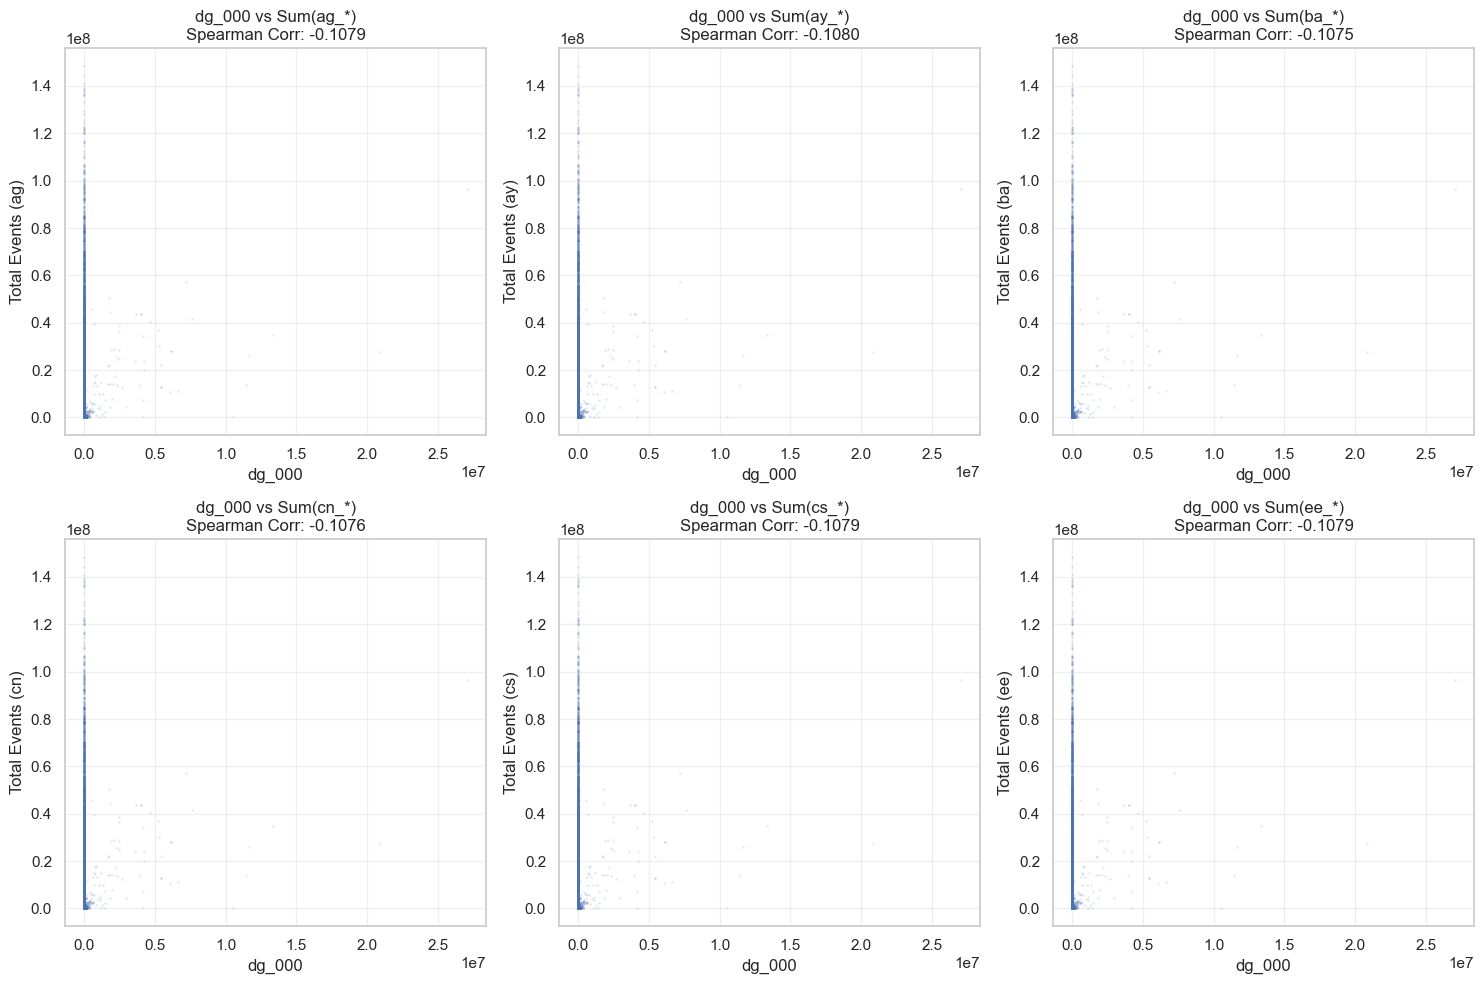


--- Top 10 Features Correlated with dg_000 ---
dg_000               1.000000
df_000               0.823692
cj_000               0.289563
ay_006               0.196103
bz_000               0.160760
ag_007               0.159252
bk_000_is_missing    0.155279
ay_005               0.146549
cn_001               0.144551
bl_000               0.144237
cs_006               0.143744
dtype: float64

--- Class Distribution by dg_000 ---


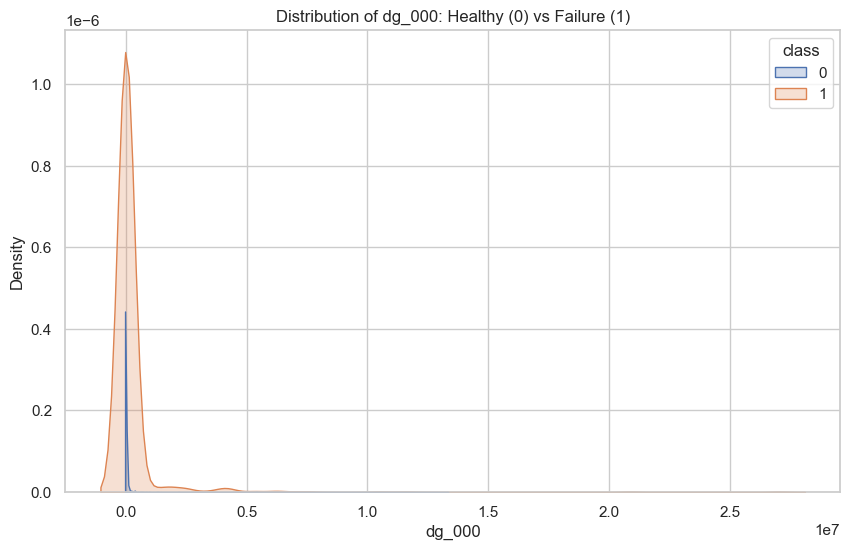

         count           mean           std  min  25%  50%  75%         max
class                                                                      
0      58999.0    1775.219851  8.819369e+04  0.0  0.0  0.0  0.0  13315810.0
1       1000.0  209376.518000  1.391528e+06  0.0  0.0  0.0  0.0  27064294.0


In [59]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='dg_000')


=== Analysis for Reference Column: cb_000 ===


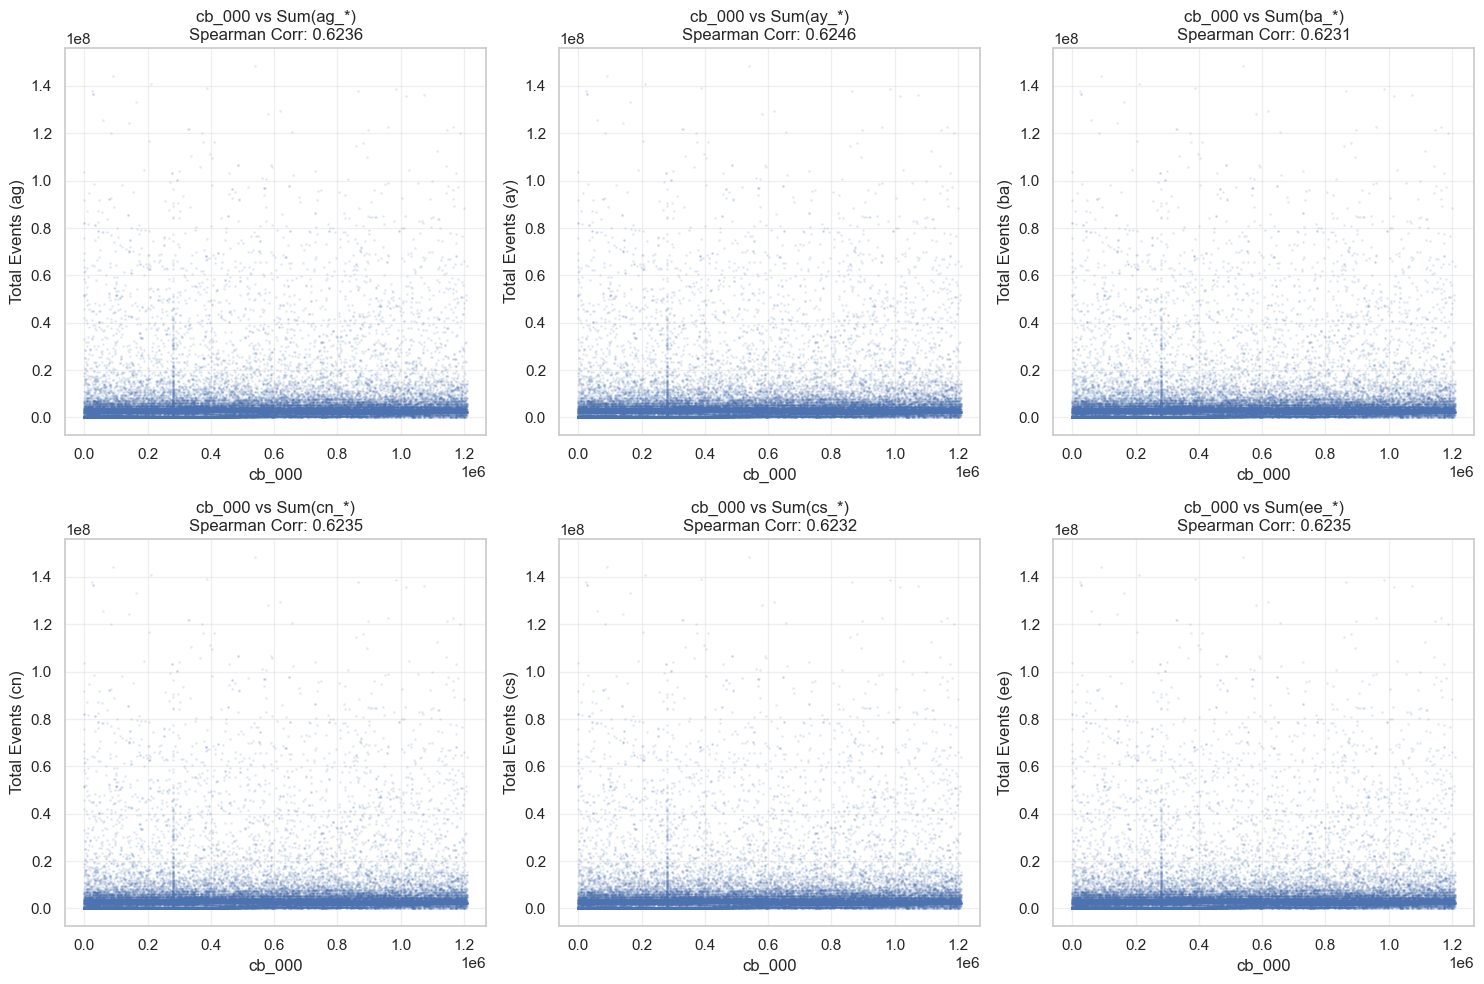


--- Top 10 Features Correlated with cb_000 ---
cb_000    1.000000
bs_000    0.915162
ca_000    0.857444
bu_000    0.670618
bv_000    0.670618
cq_000    0.670618
bb_000    0.669984
dn_000    0.668546
bj_000    0.667018
bh_000    0.666275
an_000    0.664495
dtype: float64

--- Class Distribution by cb_000 ---


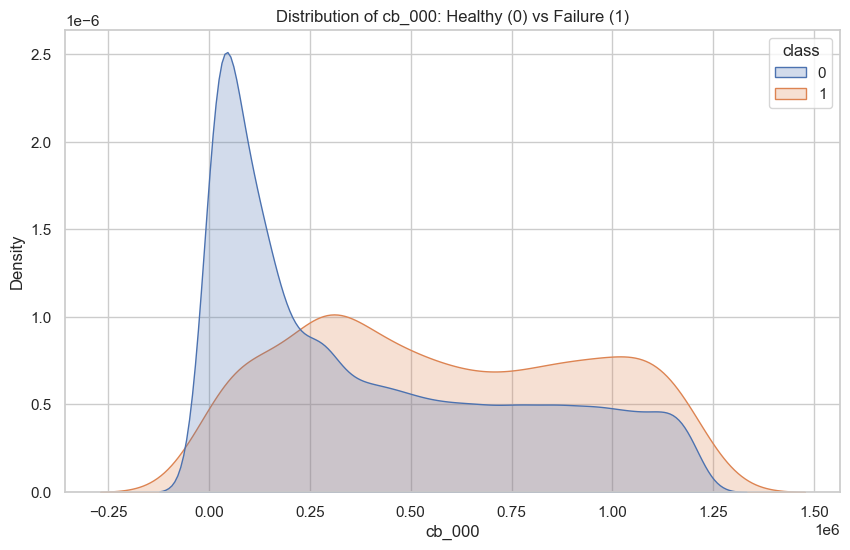

         count           mean            std  min       25%       50%  \
class                                                                   
0      58999.0  401133.781251  366855.902407  0.0   77290.0  278960.0   
1       1000.0  578794.300000  357295.175793  0.0  278960.0  548940.0   

            75%        max  
class                       
0      694280.0  1209520.0  
1      897255.0  1207560.0  


In [60]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='cb_000')


=== Analysis for Reference Column: bs_000 ===


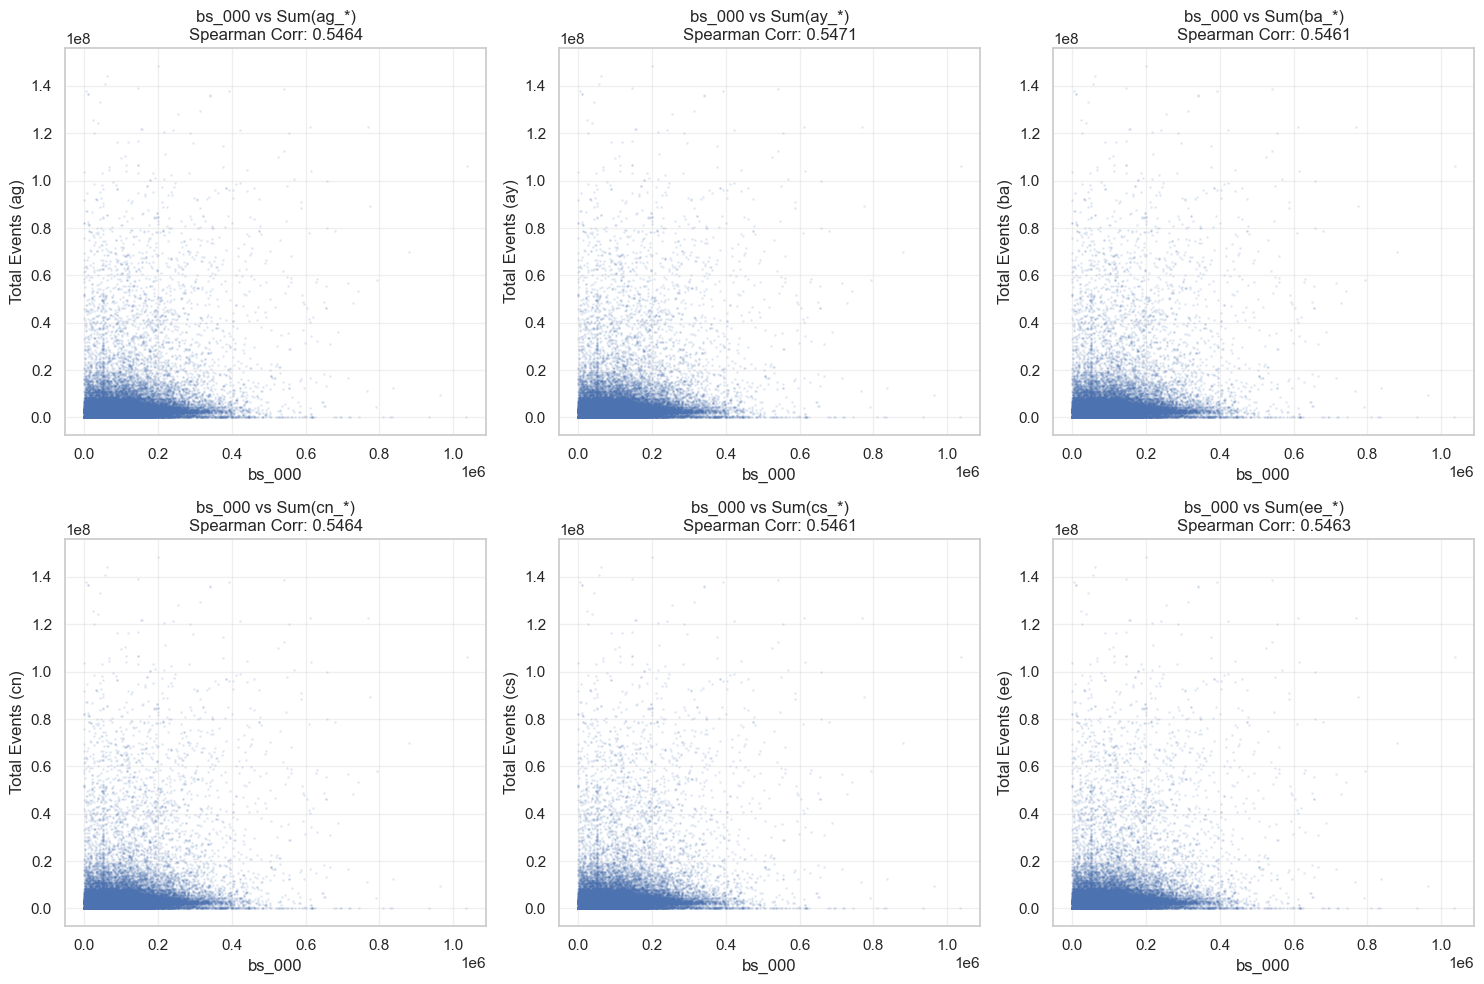


--- Top 10 Features Correlated with bs_000 ---
bs_000    1.000000
cb_000    0.915162
ca_000    0.767794
ap_000    0.676935
bi_000    0.666583
bj_000    0.648259
dn_000    0.635774
aq_000    0.625851
bh_000    0.617215
bv_000    0.611006
cq_000    0.611006
dtype: float64

--- Class Distribution by bs_000 ---


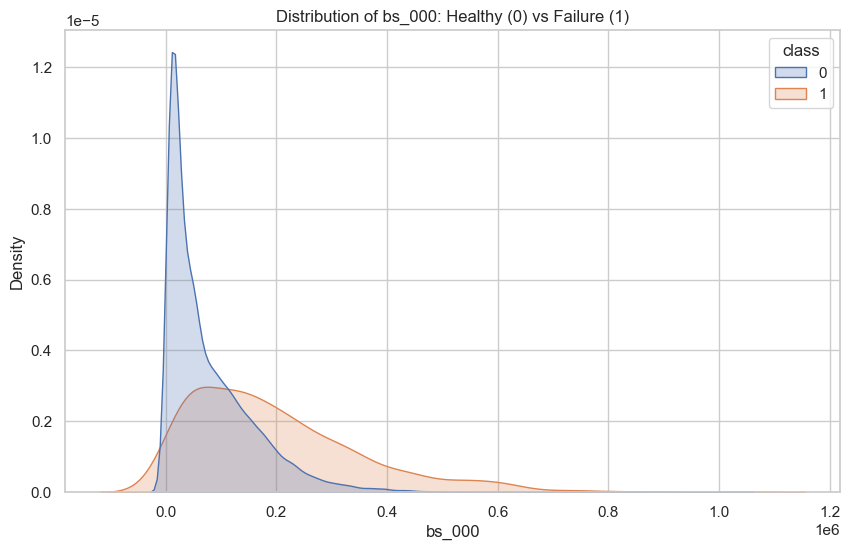

         count           mean            std  min      25%       50%  \
class                                                                  
0      58999.0   78007.382498   80843.814411  0.0  17290.0   50540.0   
1       1000.0  197391.800000  156143.152170  0.0  72780.0  162990.0   

            75%        max  
class                       
0      115560.0  1034620.0  
1      278385.0  1037240.0  


In [61]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='bs_000')


=== Analysis for Reference Column: ag_000 ===


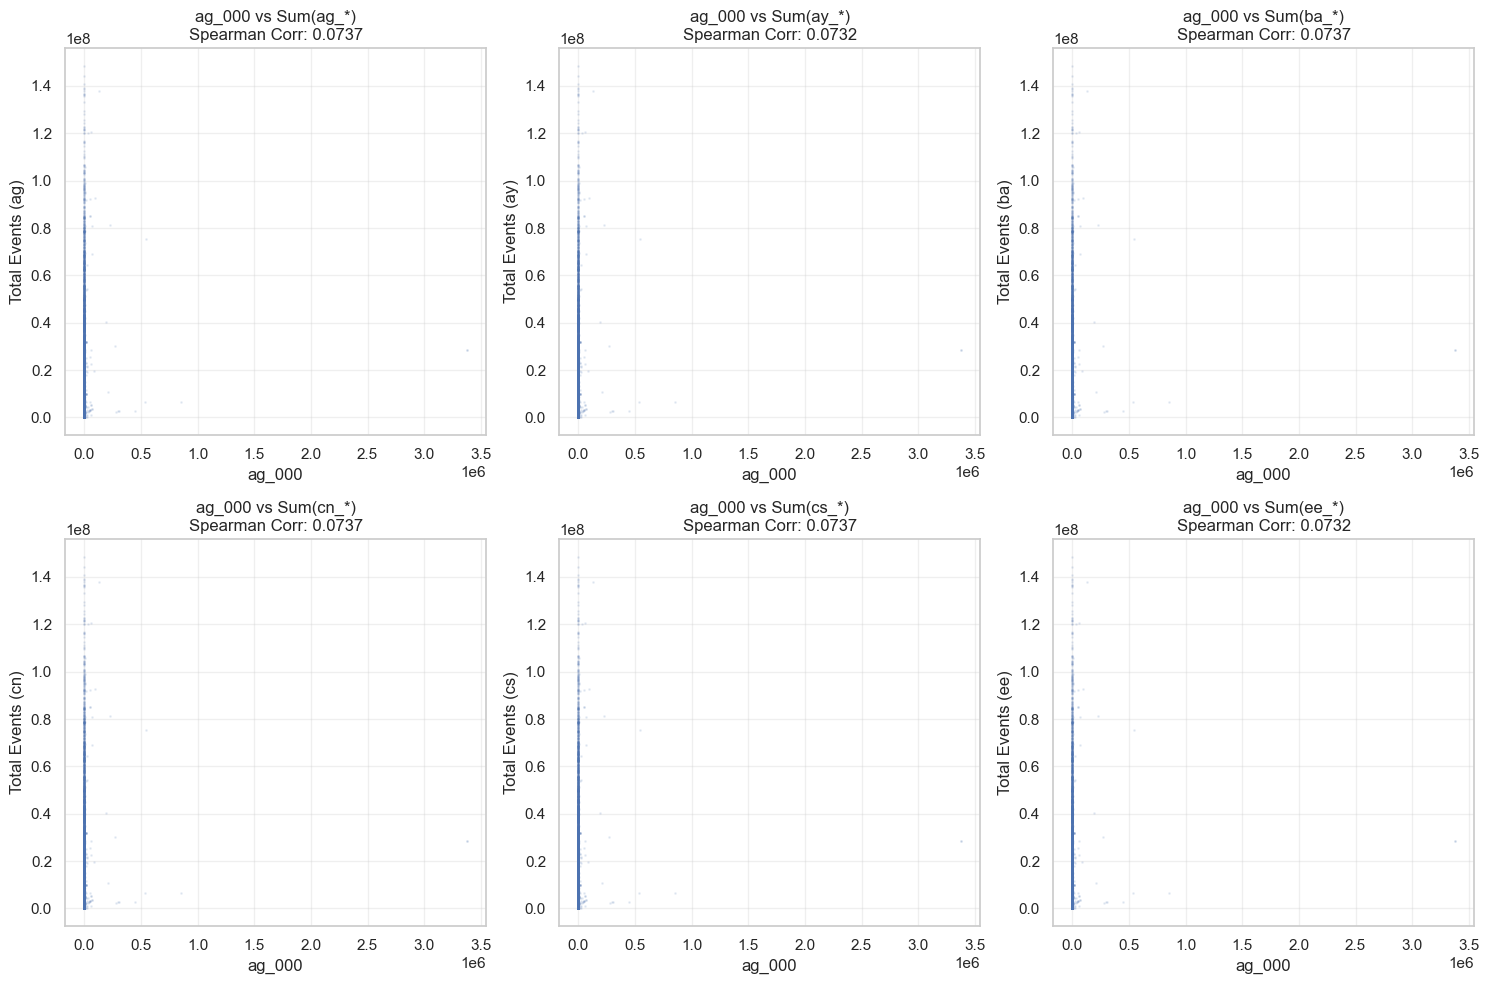


--- Top 10 Features Correlated with ag_000 ---
ag_000               1.000000
ag_001               0.472290
ag_002               0.229437
cn_000               0.166256
ay_009               0.165249
ag_003               0.113847
ai_000               0.100141
di_000_is_missing    0.085285
eb_000_is_missing    0.085271
dk_000_is_missing    0.085271
dj_000_is_missing    0.085271
dtype: float64

--- Class Distribution by ag_000 ---


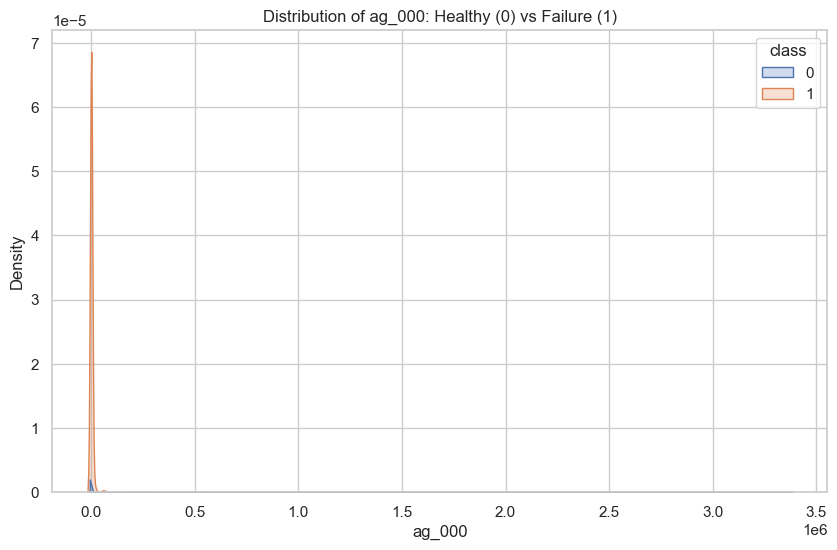

         count         mean           std  min  25%  50%  75%        max
class                                                                   
0      58999.0   186.412956  20329.867417  0.0  0.0  0.0  0.0  3376892.0
1       1000.0  2151.286000  22200.958923  0.0  0.0  0.0  0.0   544866.0


In [65]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='ag_000')


=== Analysis for Reference Column: bk_000 ===


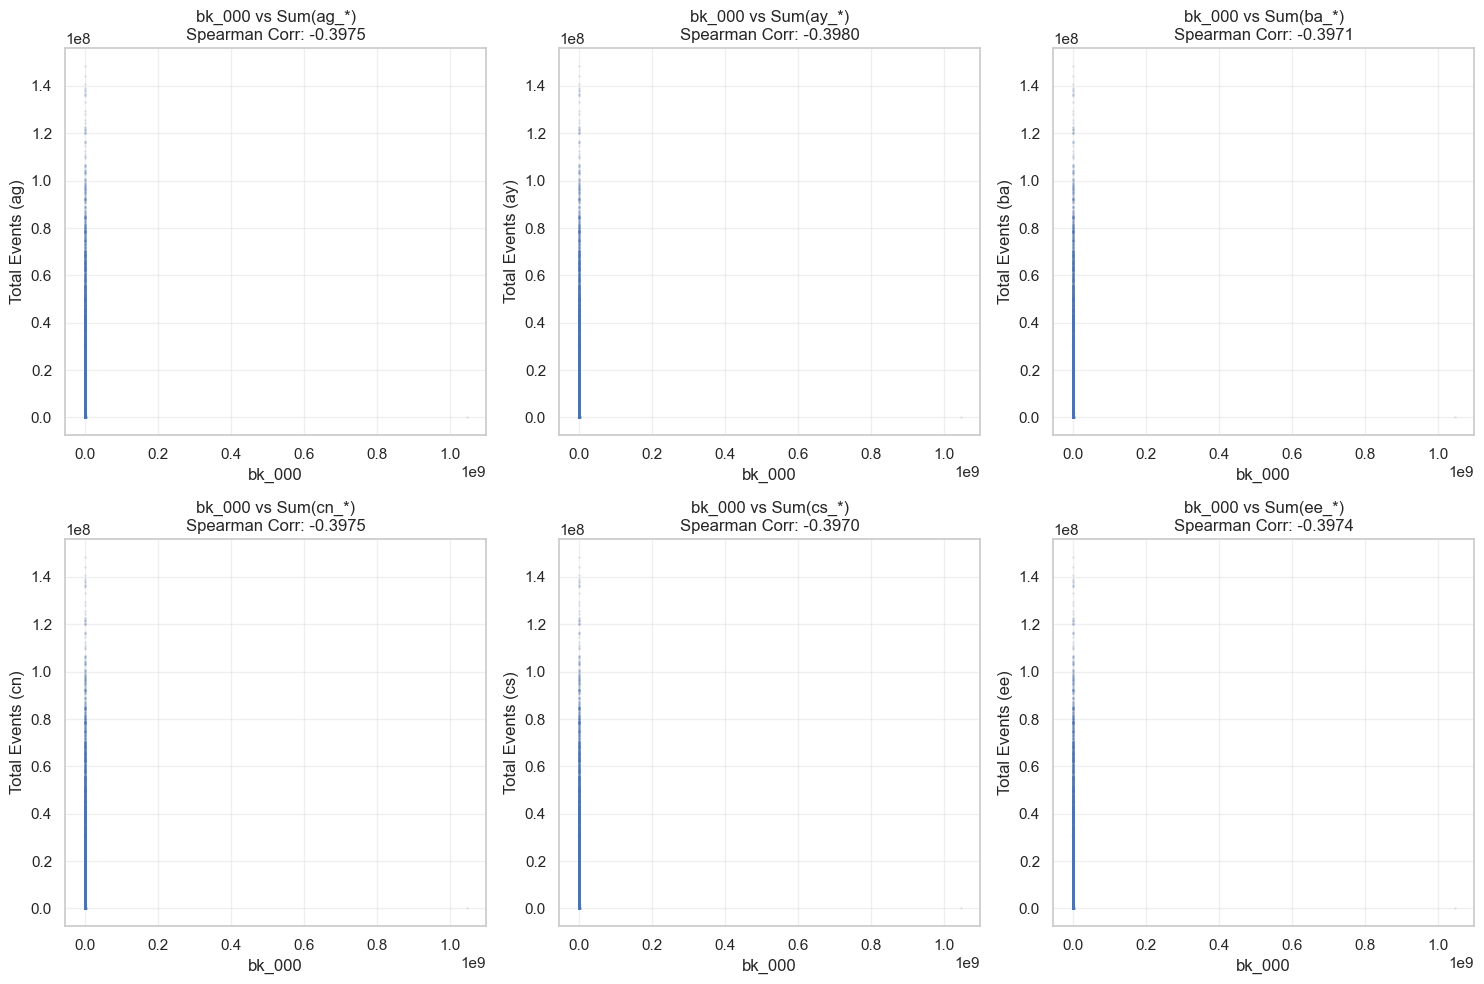


--- Top 10 Features Correlated with bk_000 ---
bk_000               1.000000
bl_000               0.801674
bm_000               0.726601
ee_008               0.501834
do_000               0.496632
dp_000               0.492516
ee_009               0.476736
bk_000_is_missing    0.474567
ay_006               0.467600
ao_000               0.458775
ag_007               0.445345
dtype: float64

--- Class Distribution by bk_000 ---


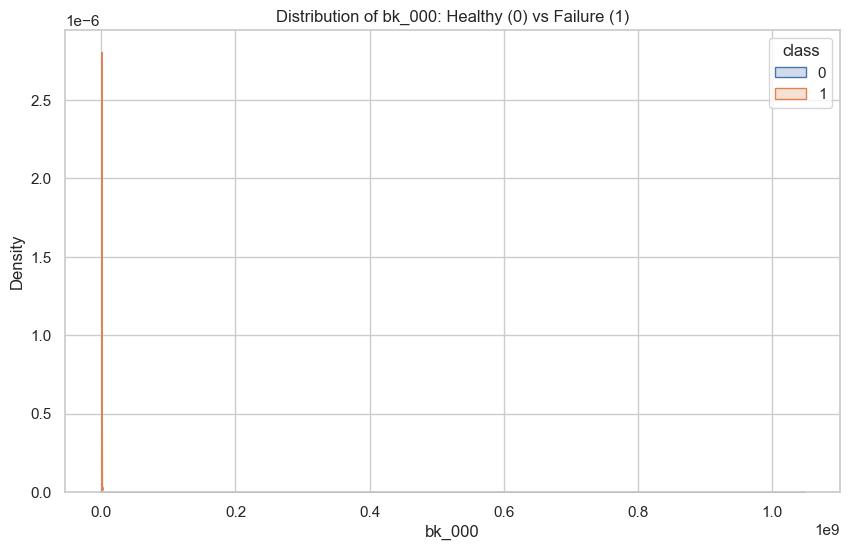

         count           mean           std            min       25%  \
class                                                                  
0      58999.0  303424.986386  4.316332e+06  -75728.359313  190560.0   
1       1000.0  388478.919196  1.917238e+05 -831541.512474  263475.0   

                 50%            75%           max  
class                                              
0      288095.559987  296909.041597  1.047494e+09  
1      342850.000000  483700.000000  1.310700e+06  


In [66]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='bk_000')


=== Analysis for Reference Column: ai_000 ===


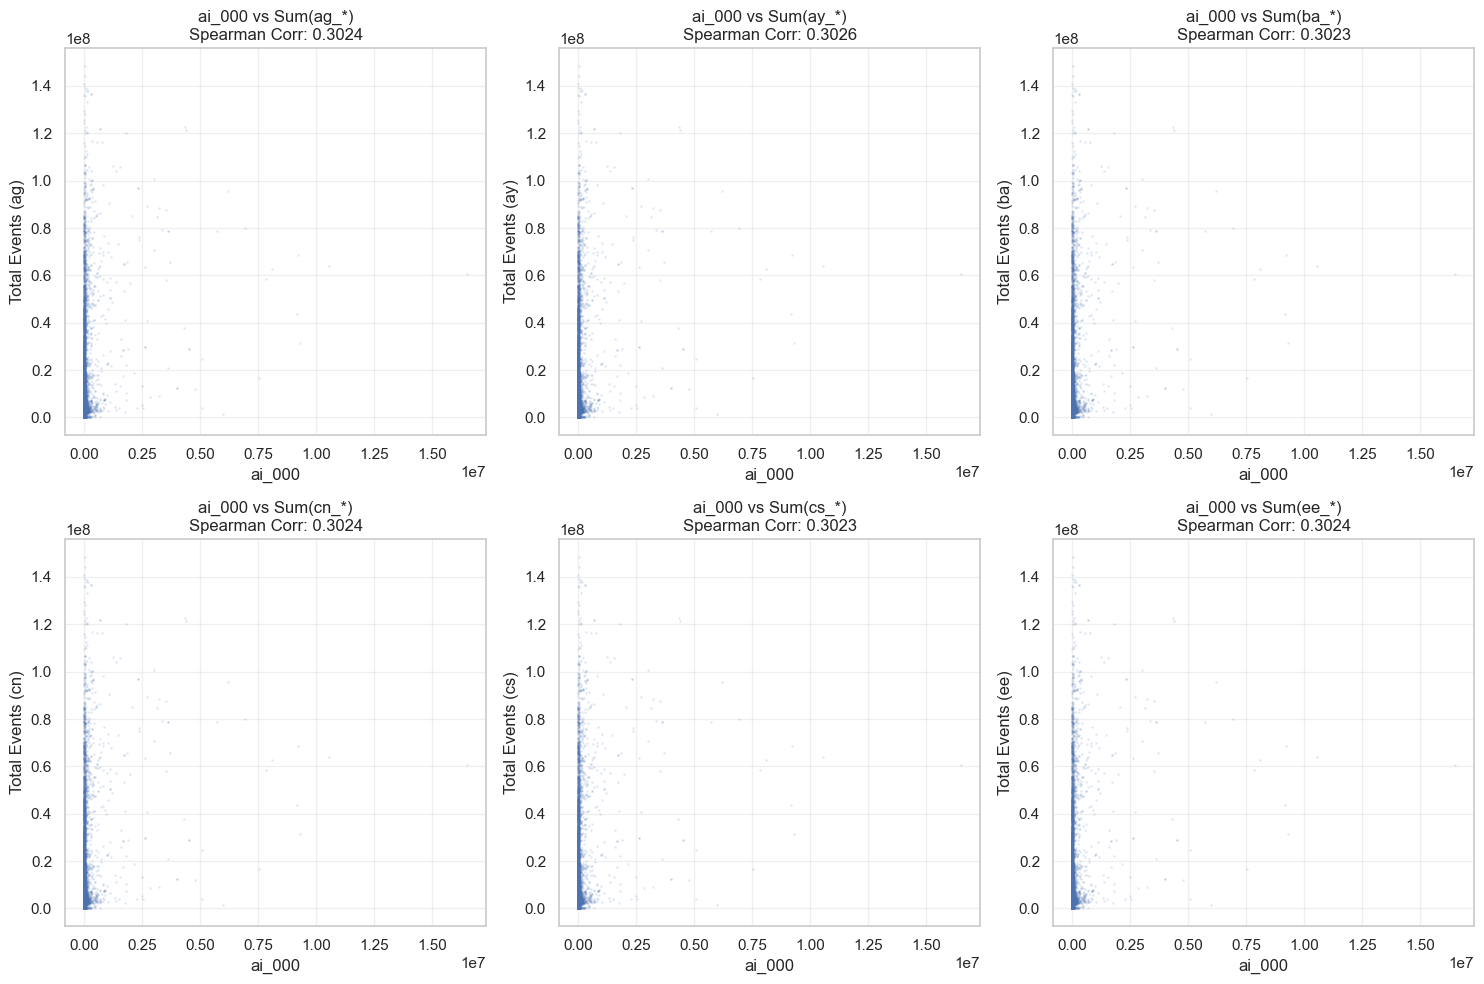


--- Top 10 Features Correlated with ai_000 ---
ai_000    1.000000
bj_000    0.382484
aq_000    0.375167
ap_000    0.364150
dn_000    0.363845
bh_000    0.349362
ck_000    0.337198
bi_000    0.332741
bb_000    0.321590
ah_000    0.320805
bu_000    0.320672
dtype: float64

--- Class Distribution by ai_000 ---


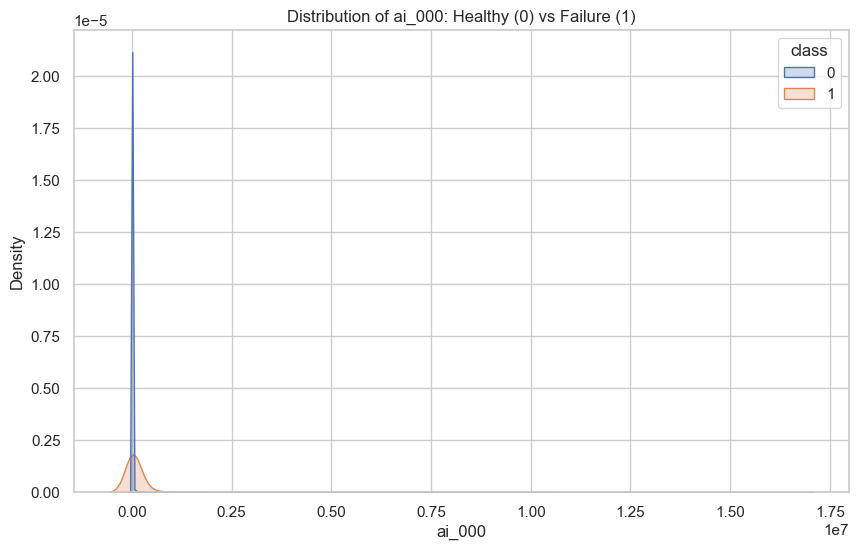

         count           mean            std  min  25%     50%      75%  \
class                                                                     
0      58999.0    6421.613553  128908.596354  0.0  0.0     0.0      0.0   
1       1000.0  156477.476000  762154.004777  0.0  0.0  8456.0  53520.0   

              max  
class              
0      10552482.0  
1      16512852.0  


In [67]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='ai_000')


=== Analysis for Reference Column: az_006 ===


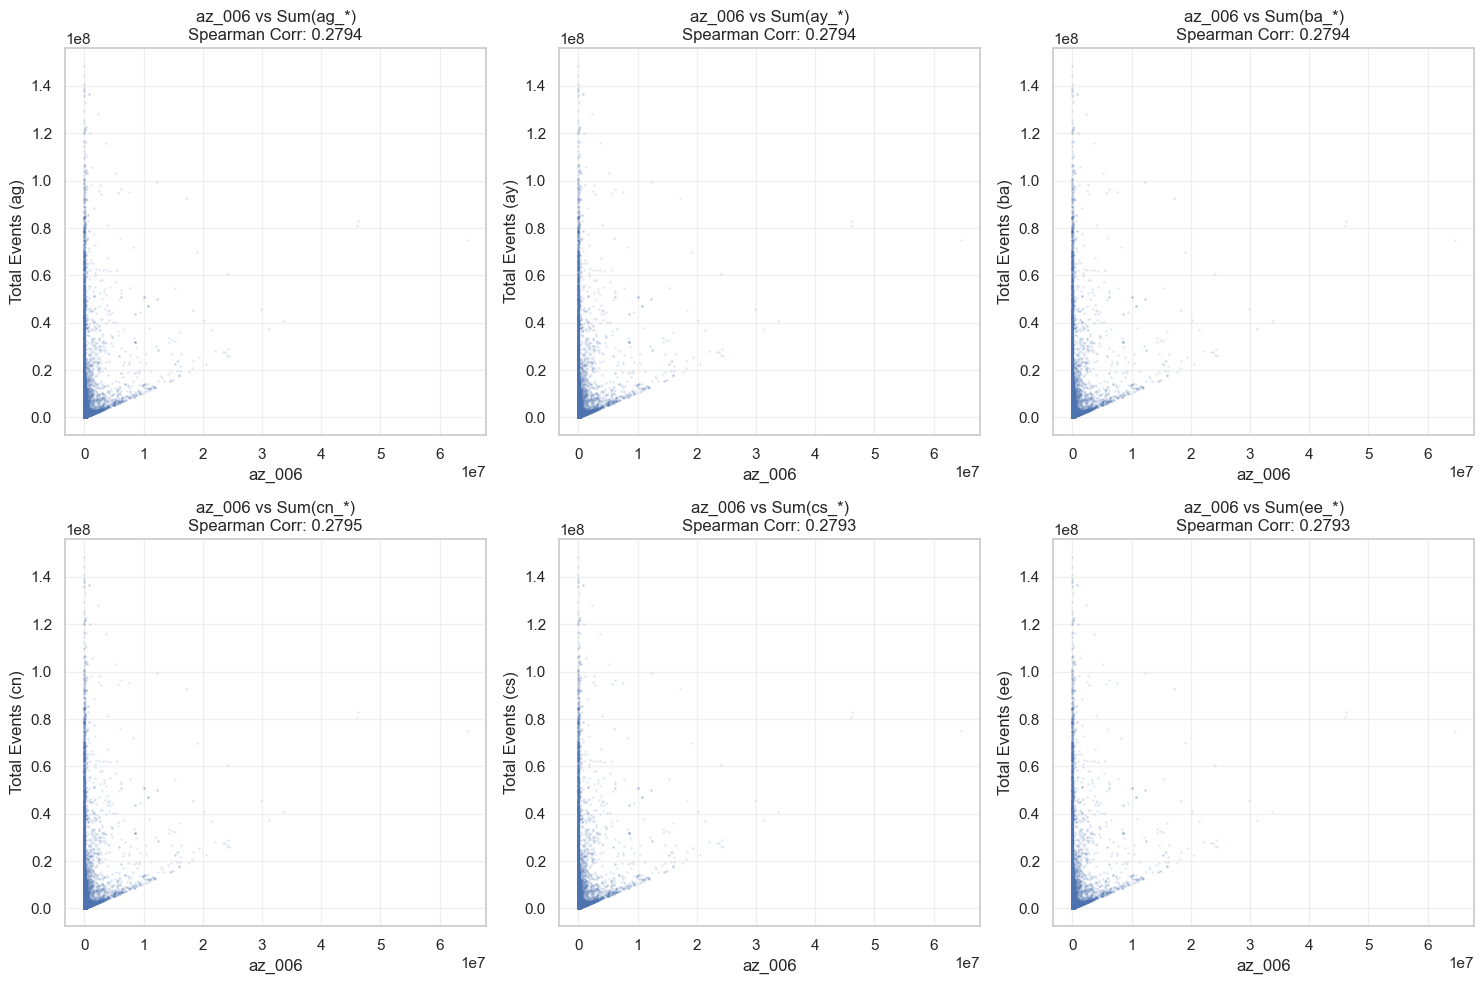


--- Top 10 Features Correlated with az_006 ---
az_006    1.000000
az_007    0.470908
ag_004    0.375731
cn_003    0.345432
ag_005    0.342903
cs_000    0.319921
cs_007    0.310908
ba_005    0.307242
cn_002    0.307118
cs_001    0.304953
ba_006    0.302991
dtype: float64

--- Class Distribution by az_006 ---


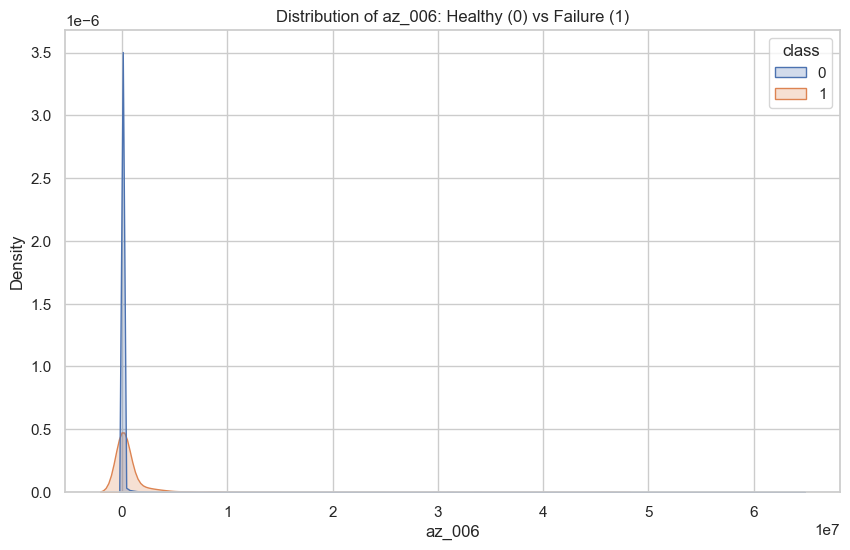

         count           mean           std  min   25%     50%       75%  \
class                                                                      
0      58999.0   89591.236835  7.990099e+05  0.0  10.0   292.0    3982.0   
1       1000.0  710088.588000  2.748007e+06  0.0  10.0  1201.0  213106.0   

              max  
class              
0      64589140.0  
1      46170334.0  


In [68]:
analyze_feature_relationships(X_clean, y_train_raw, reference_col='az_006')